# ASTR3110 Computer Laboratory 3: Classifying Images using Artificial and Convolutional Neural Networks.


In this Lab, you will be using imaging from the [CORNISH](https://cornish.leeds.ac.uk/public/index.php) survey to classify images using Neural Networks. The CORNISH survey aimed to understand massive star formation in our Galaxy by searching for ultra-compact HII regions (regions that have stars with mass > 8 times the mass of our Sun that are ionising the surrounding gas, which emit at radio wavelengths) in a portion of the plane of the disk of the Galaxy using the [Very Large Array Radio telescope](http://www.vla.nrao.edu). 

While this survey successfully discovered many new HII regions, other sources such as planetary nebulae (PNE) and background galaxies (RGs) also emit at radio wavelengths, and so were also detected in the survey data. By design, the CORNISH survey targetted a region that also contained observations in the mid-infrared taken drung another survey with the Spitzer Space telescope ([the GLIMPSE survey](https://irsa.ipac.caltech.edu/data/SPITZER/GLIMPSE/)). In particular, the 4.5, 5.8, and 8.0 $\mu$m Spitzer images allow us to distinguish HII regions, PNE, and RGs due to their differnt appearance (see top panel in the below image: leftmost is a PNE, middle a HII region, and right a RG).

![SegmentLocal](CORNISH_image.png)

In the first part of the lab, you will train and test an Artificial Neural Network classifier using 300 8.0 $\mu$m images (100 each for HII, PNE, and RG sources).

In the second part of the lab, you will train and test a Convolutional Neural Network classifier, using the same sample as in Part One, but adding the 4.5 and 5.8 $\mu$m images. 

In both parts, you will need to run tests to determine the performance of your classifier, and tweak hyperparameters  in order to improve the performance. (N.B.: The term "hyperparameter" is reserved for those parameters that are set manually, e.g., the number of components in GMM, or the learning rate of your neural network. Normal parameters are determined from the data, e.g., the intercept and slope of a straight line fit)

At the completion of this lab, you will have acquired (or improved) the following skills:
- Reading in fits images using astropy.
- Manipulating 2D image arrays to prepare them for input into the ANN and CNN architectures (using the ndimage and numpy packages).
- Using the keras packages for setting up and running ANN and CNN. classifiers.
- Using Scikit Learn and other packages to assess the performance of ANN and CNN classifiers.

# Part 1: Artificial Neural Networks

In this part, we will use the 8.0 $\mu$m images to design a classifier using the keras backend to build ANNs in a similar manner to that described in the [Week 9 lectorial](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_9_ANNs.ipynb). First, the data must be read in and manipulated into a format that is accepted by the keras models.

## Accessing the data.


<font color='red'>

You should clone the Github repository to your Google Drive as per the usual method [described here](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/SETUP_COLAB.md). **Please clone into a new directory so that you do not overwrite existing Labs!!**

As outlined above, the data that will be used in this lab consist of Spitzer imaging in the 4.5, 5.8, and 8.0 $\mu$m bands. The images have been uploaded to the [Github repository](https://github.com/MQ-ASTR3110-2021/ASTR3110_Practical_Notebooks_2021/), and are stored the main ```Cornish_data``` directory, which contains three subdirectories: one each for ```HII```, ```PNE```, and ```RG``` sources. Within each of these subdirectories, there are 300 "fits" files: 3 files for each source, where the filename gives the Galactic coordinates, and the 3 fiels are for the different Spitzer bands (I2 = 4.5 $\mu$m, I3 = 5.8 $\mu$m, and I4 = 8.0 $\mu$m). </font>

In [ ]:
# Importing all the necessary modules and functions:
import numpy as np
import glob
import itertools

from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.models import Sequential # Model used to create the architecture both ANNs and CNNs
from keras.layers.core import Dense 
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D # For CNNs
from keras.layers.convolutional import MaxPooling2D # For CNNs
from keras.layers.core import Flatten # For CNNs
from keras.layers.core import Activation # For CNNs
from keras.layers.core import Dropout # For CNNs

# dir = 'Cornish_data/'
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setting path variables

In [ ]:
root = 'gdrive/MyDrive/ASTR3110/OLD/Prac03'
data = '/Cornish_data'

###  Getting to know the data

<font color='red'>The fits format is commonly used for storing astronomical data, and can store binary tables, images, cubes, and other formats (the format is also used by Garmin, Strava and other activity trackers), as well as coordinate and information for the image in a header. Fits files can be read into numpy arrays using the [astropy.io.fits](https://docs.astropy.org/en/stable/io/fits/#) package. 

Using the astropy.io.fits.getdata() function, read in a source from each of the HII, PNE, and RG folders. At this point, we only require access to the 8.0 $\mu$m band images (labelled \*_I4.fits). Using numpy functions, determine basic statistics for the images (min, max pixel values, and shape of the array). Plot the images for the three sources to convince yourself that they appear different.</font>

In [ ]:
hii_1 = fits.getdata(root + '/' + data + '/HII/G011.1712-00.0662_I4.fits')
hii_2 = fits.getdata(root + '/' + data + '/HII/G011.1104-00.3985_I4.fits')
hii_3 = fits.getdata(root + '/' + data + '/HII/G010.8519-00.4407_I4.fits')

pne_1 = fits.getdata(root + '/' + data +'/PNE/G009.9702-00.5292_I4.fits')
pne_2 = fits.getdata(root + '/' + data +'/PNE/G010.0989+00.7393_I4.fits')
pne_3 = fits.getdata(root + '/' + data +'/PNE/G010.4168+00.9356_I4.fits')

rg_1 = fits.getdata(root + '/' + data +'/RG/G010.0500-00.6863_I4.fits')
rg_2 =  fits.getdata(root + '/' + data +'/RG/G011.7182-00.9321_I4.fits')
rg_3 = fits.getdata(root + '/' + data +'/RG/G011.9222+01.0978_I4.fits')

plotting from https://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html

to change the min pixel values https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

In [ ]:
hii_1.shape

(302, 302)

Images are shape 302x302

In [ ]:
from matplotlib.colors import LogNorm

Plotting to see what these 9 images look like

Text(0.5, 1.0, 'rg_3')

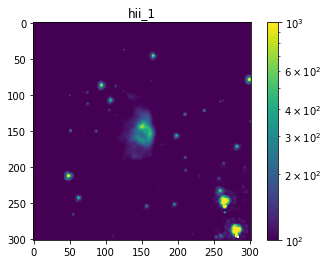

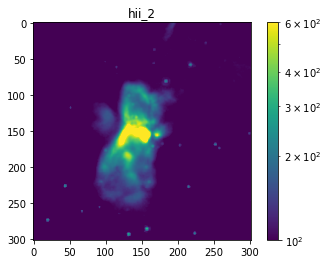

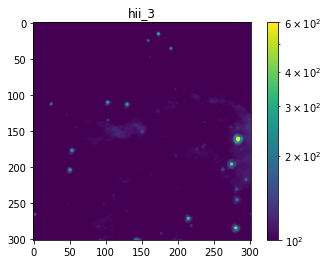

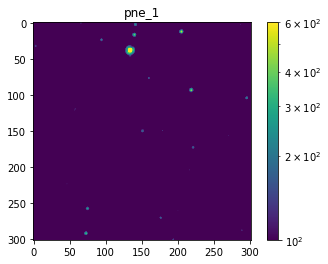

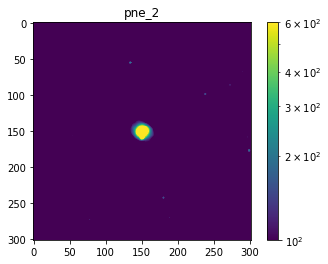

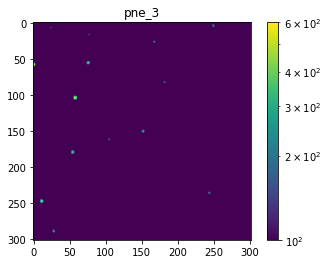

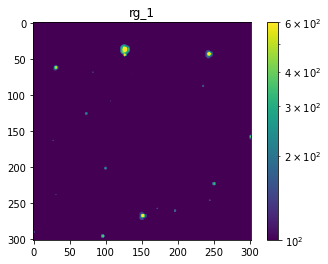

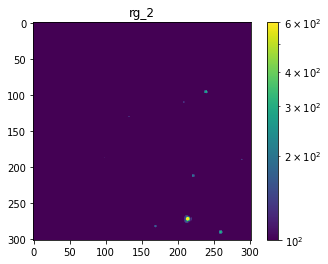

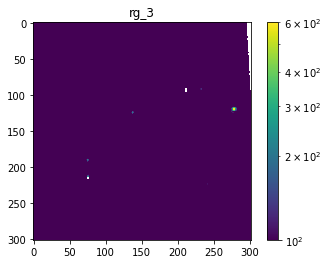

In [ ]:
# print(hii_1)
plt.figure()
plt.imshow(hii_1,vmin=100,vmax=1000,norm=LogNorm()) #log scaling for the pixels. Makes makes darker pixels more noticeable
#and the brighter pixels less intense. 

# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1')

plt.figure()
plt.imshow(hii_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii_2')

plt.figure()
plt.imshow(hii_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii_3')

#---------------------------------------------------------

plt.figure()
plt.imshow(pne_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('pne_1')


plt.figure()
plt.imshow(pne_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('pne_2')

plt.figure()
plt.imshow(pne_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('pne_3')

#---------------------------------------------------------


plt.figure()
plt.imshow(rg_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('rg_1')


plt.figure()
plt.imshow(rg_2,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('rg_2')

plt.figure()
plt.imshow(rg_3,vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('rg_3')

<font color='red'>
Because the images are relatively large, we want to resize them in order to decrease the runtime when we run our neural networks. Use the [scipy.ndimage.zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html) function to bin the images to a coarser pixel scale. Plot the resulting coarsely binned image and compare with the original for each of the three sources. Try a few different 'zoom' factors and choose a suitable factor by which to reduce the size of your images. Note, you do not want to bin too much, otherwise you lose too much information. 

</font>

Using the `zoom` function to zoom into the images.

In [ ]:
from scipy import ndimage, misc

hiiZoom_1 = ndimage.zoom(hii_1,0.5)
hiiZoom_2 = ndimage.zoom(hii_2,0.5)
hiiZoom_3 = ndimage.zoom(hii_3,0.5)

pneZoom_1 = ndimage.zoom(pne_1,0.5)
pneZoom_2 = ndimage.zoom(pne_2,0.5)
pneZoom_3 = ndimage.zoom(pne_3,0.5)

rgZoom_1 = ndimage.zoom(rg_1,0.5)
rgZoom_2 = ndimage.zoom(rg_2,0.5)
rgZoom_3 = ndimage.zoom(rg_3,0.5)


Plotting only two images to check if they have been zoomed. 

Text(0.5, 1.0, 'hii_1 zoom')

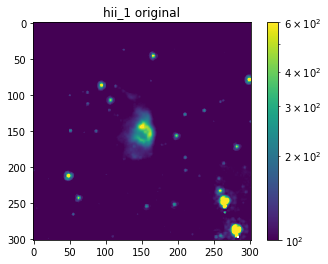

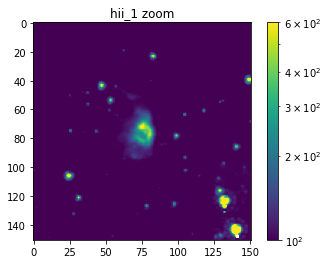

In [ ]:
plt.figure()
plt.imshow(hii_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1 original')

plt.figure()
plt.imshow(hiiZoom_1,vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_1 zoom')

They have been zoomed

## Preparing the data for the ANN


As you know from lectorial 9, as input to the ANN we require the images to be flattened to 1D arrays, and also normalised so that the pixel values are between 0 and 1. We also require labels for the sources (both single digit labels as well as the one-hot vectors of binarized labels), and a training and testing/validation sample. 

To achieve some of the above, I suggest that you write a function that:
- accepts a directory path + fits filename (e.g., Cornish_data/HII/G010.8519-00.4407_I4.fits),
- reads the fits file using astropy.io.getdata,
- resizes the image,
- normalises the pixels values to be between 0 and 1,
- flattens the 2D images into 1D,
- returns the resized, normalised, flattened 1D array

You can use the [glob](https://docs.python.org/3/library/glob.html) function to return a list of filenames that can be looped over and read in by your function. You will need to stack each flattened image into a larger array that contains all 300 sources. In addition, you will need the corresponding 1D vector of labels, as well as the binarized version.

Finally, you will need to split your data into a training and testing/validation dataset (recall scikit learn's handy [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function).</font>

## Reading the data as a function

glob gives list of all the names. 

In [ ]:
import glob

There are 100 files for each object (hii, pne, rg) so a total of 300 files. Using the `glob.glob` function is already inside the directory where the data is located. 

In [ ]:
def globFn(objectDir: str):
    #stores the file names in a list
    fitsFileNames = glob.glob(root + data + '/' + objectDir +'/*_I4.fits') # Where the asterisk symbol acts as a wildcard
    return fitsFileNames

In [ ]:
def readFileFn(objectDir: str):
    fitsImages= []
    files=(globFn(root + data + '/' + objectDir))
    #uses the stored file names and gets the data from them with the fits.getdata function, stores it in a list. 
    for i in files:
        fitsImages.append(fits.getdata(i))
    return fitsImages

Calling the function for each object, `glob.glob` is case sensitive:

The above function `readFileFn` isn't working, so taking the code out of the function to do it manually: 

In [ ]:
hii_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/HII' + '/*_I4.fits'):
  hii_DF_raw.append(fits.getdata(i))


pne_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/PNE' + '/*_I4.fits'):
  pne_DF_raw.append(fits.getdata(i))


rg_DF_raw = []
for i in glob.glob('gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG' + '/*_I4.fits'):
  rg_DF_raw.append(fits.getdata(i))

To confirm the shapes of the DFs, so that we know our functions have worked: 

In [ ]:
print(len(hii_DF_raw))
print(len(pne_DF_raw))
print(len(rg_DF_raw))

100
100
100


Checking the size of a single image in the collection:

In [ ]:
len(rg_DF_raw[0])

302

## Resizing and reshaping the images

In [ ]:
def resizeFn(DF,zoomFactor):
    DF_zoom= ndimage.zoom(DF, zoomFactor)
    return DF_zoom

zoomFactor= (1,0.5,0.5)
hii_DF_zoom = resizeFn(hii_DF_raw, zoomFactor)
pne_DF_zoom = resizeFn(pne_DF_raw,zoomFactor)
rg_DF_zoom = resizeFn(rg_DF_raw, zoomFactor)

In [ ]:
rg_DF_zoom.shape

(100, 151, 151)

The following cell has only a single value for the zoom factor, like how Brandon has done it. I'm not sure why the previous cell had a list of values. 

In [ ]:
def resizeFn(DF,zoomFactor):
    DF_zoom= ndimage.zoom(DF, zoomFactor)
    return DF_zoom

zoomFactor= 0.6
hii_DF_zoom = resizeFn(hii_DF_raw, zoomFactor)
pne_DF_zoom = resizeFn(pne_DF_raw,zoomFactor)
rg_DF_zoom = resizeFn(rg_DF_raw, zoomFactor)

In [ ]:
rg_DF_zoom.shape

(60, 181, 181)

Confirming the resize worked: 

Text(0.5, 1.0, 'hii_2 zoom')

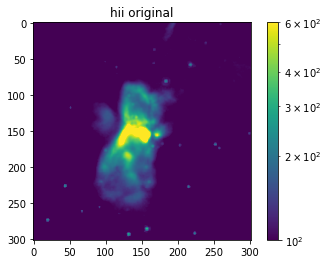

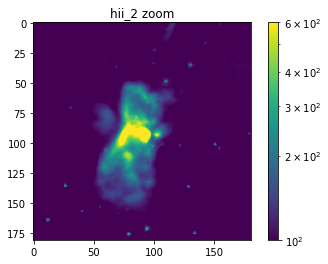

In [ ]:
plt.figure()
plt.imshow(hii_DF_raw[0],vmin=100,vmax=600,norm=LogNorm())
plt.colorbar()
plt.title('hii original')

plt.figure()
plt.imshow(hii_DF_zoom[0],vmin=100,vmax=600,norm=LogNorm())
# plt.imshow(hii_1,norm=LogNorm())
plt.colorbar()
plt.title('hii_2 zoom')

Checking the axes, we can see the images have been resized. 

## Normalisation

In [ ]:
arrZeros= np.zeros((100,181,181))
for i in range(len(hii_DF_zoom)):
    arrZeros[i,:,:] = hii_DF_zoom[i,:,:] - hii_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    hiiDF_norm= arrZeros
hiiDF_norm.shape

(100, 181, 181)

Confirming the normalisation worked

In [ ]:
print('max value: ',hiiDF_norm.max(),'and min value: ', hiiDF_norm.min())

max value:  1.0 and min value:  0.0


Performing the same normalisation for the other two objects: 

In [ ]:
arrZeros= np.zeros((100,181,181))
for i in range(len(pne_DF_zoom)):
    arrZeros[i,:,:] = pne_DF_zoom[i,:,:] - pne_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    pneDF_norm = arrZeros    
pneDF_norm.shape

(100, 181, 181)

In [ ]:
arrZeros= np.zeros((100,181,181))
for i in range(len(rg_DF_zoom)):
    arrZeros[i,:,:] = rg_DF_zoom[i,:,:] - rg_DF_zoom[i,:,:].min()
    arrZeros[i,:,:] = arrZeros[i,:,:]/arrZeros.max()
    rgDF_norm= arrZeros
rgDF_norm.shape

(100, 181, 181)

Now we want to flatten the images so that we can feed the ANN with 1D arrays. So first let's create an array to store the dimension of our DF

In [ ]:
hii_DFdim = hiiDF_norm.shape

pne_DFdim = pneDF_norm.shape

rg_DFdim = rgDF_norm.shape
rg_DFdim

(100, 181, 181)

## Flattening

Flattening the images

In [ ]:
len(hiiDF_norm[0].flatten())

32761

In [ ]:
all_flat = []
for i, val in enumerate(hiiDF_norm):
  all_flat.append(hiiDF_norm[i].flatten())

for i, val in enumerate(pneDF_norm):
  all_flat.append(pneDF_norm[i].flatten())

for i, val in enumerate(rgDF_norm):
  all_flat.append(rgDF_norm[i].flatten())

all_flat = np.array(all_flat)

In [ ]:
all_flat.shape

(300, 32761)

## Now will need the corresponding 1D vector of labels, as well as the binarized version

In [ ]:
#creating the labels
hii_fileName = globFn('HII')
pne_fileName = globFn('PNE')
rg_fileName = globFn('RG')

#we want to now binarize these labels so that we can use them in our `trainTestSplitFn`
rg_fileName[0:10]

['gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G010.0500-00.6863_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.7182-00.9321_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G013.8826+00.5410_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.9222+01.0978_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G017.8566-00.0002_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G012.1225-00.5000_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G013.8700+00.5408_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G017.6618-00.3327_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G011.9709+00.1913_I4.fits',
 'gdrive/MyDrive/ASTR3110/OLD/Prac03/Cornish_data/RG/G012.6550-00.9622_I4.fits']

In [ ]:
allFileNames = np.concatenate((hii_fileName, pne_fileName, rg_fileName))
allFileNames.shape

(300,)

All the file names are in one list. Digitizing the strings:

In [ ]:
labels = []

for i in range(len(allFileNames)):
#     print(i)
    if 'HII' in allFileNames[i]:
        labels.append(0)
#     if allFileNames[i]=='*PNE*' :
    if 'PNE' in allFileNames[i]:
        labels.append(1)
#     if allFileNames[i]=='*RG*' :
    if 'RG' in allFileNames[i]:
        labels.append(2)
        
labels= np.array(labels)
labels.shape

(300,)

In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

we have our digitized 1D vector of labels `labels`. Splitting the dataframe and labels into train and test sets:

In [ ]:
from sklearn.model_selection import train_test_split

#splitting the DF with the split function
trainSet, testSet, trainLabels, testLabels= train_test_split(all_flat, labels, stratify= labels, test_size= 0.3, random_state= 42)

testSet.shape

(90, 32761)

the first dimension, 90, represents 30% of 300 (all of our files)

In [ ]:
print('train_labels shape: ', trainLabels.shape, 'and test_labels shape: ', testLabels.shape)

train_labels shape:  (210,) and test_labels shape:  (90,)


Everything has been split correctly, moving on to the binarizer process: 

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #sets the function to a variable, less writing.

#converting our labels which contain 0,1,2 into one-hot vector format which is required for the binarizor function
trainLabels = lb.fit_transform(trainLabels)
testLabels = lb.transform(testLabels) 

print('train_labels shape: ', trainLabels.shape, 'and test_labels shape: ', testLabels.shape)

train_labels shape:  (210, 3) and test_labels shape:  (90, 3)


hot vectors are now made

In [ ]:
testLabels[0:10]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

What the above represents is, whenever an index is populated with 1, this corresponds to the object. First index = HII, second = PNE, third = RG. 

## Creating a data preparation function:

In [ ]:
# Defining the function to automate the process:
def dataPrepANN(directory, zoom_factor):
    allFiles = ["HII", "PNE", "RG"] # List of strings with the object names.
    stackedArrayValues = [] # Normalised, resized and stacked 1D arrays corresponding to the images.
    stackedArrayLabels = [] # 1D array for the labels.

  # Finding all the sources in each object that ends with `_I4.fits`.
    for filetype in allFiles:
        folder = os.path.abspath(directory + '/' + filetype)
        files = glob.glob(folder + '/*_I4.fits')

    # For each source, we want to resize and normalise the image.
        for filename in files:
            data = fits.getdata(filename)
            resizeData = ndimage.zoom(data,zoom=zoom_factor) 
            # Normalisation is done by first subtracting the minimum value, and then dividing by the maximum value in the subtracted values.
            normalisedData = (resizeData-np.min(resizeData))/np.max(resizeData-np.min(resizeData))
            normalised1D = normalisedData.flatten() # Turning the 2D image into a 1D array.
            stackedArrayValues.append(normalised1D)
            stackedArrayLabels.append(filetype)

  # Converting the lists into a 1D array.
    stackedArrayValues = np.array(stackedArrayValues)
    stackedArrayLabels = np.array(stackedArrayLabels)

    # Binarising the labels once all the sources for each object were identified, resized and normalised:
    lb = LabelBinarizer()
    binarizedLabels = lb.fit_transform(stackedArrayLabels)

    return stackedArrayValues, stackedArrayLabels, binarizedLabels

In [ ]:
pixelValues, dataLabels, binarizedLabels = dataPrepANN(directory= root + data, zoom_factor=0.6)

In [ ]:
pixelValues.shape

(300, 32761)

In [ ]:
pixelValues[0].shape

(32761,)

We will binarise the labels that are currently strings, also known as hot vectors. It's better to work with hot vectors and convert back to string labels later on. `dataLabels` is the string labels and `binarizedLabels` is the hot vectors.

In [ ]:
lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(dataLabels)
print(lb.classes_)

['HII' 'PNE' 'RG']


A test set with 30% of the data is a good amount for the model. 

In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(pixelValues, binarizedLabels, test_size=0.3)

In [ ]:
print(f"Shape of trainData: {trainData.shape}")
print(f"Shape of testData: {testData.shape}")

Shape of trainData: (210, 32761)
Shape of testData: (90, 32761)


## Running the ANN

With your data prepared, you can now start building your ANN. Start off by building a Sequential ANN with the same architecture, optimizer, and hyperparameters as that used in [Lectorial 9](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_9_ANNs.ipynb), but modify the inputs so that they suit the data used here.

In [ ]:
model = Sequential() #Sequential is the model, so defining it in a variable so we can use it later.

model.add(Dense(256, input_shape=(32761,), activation="sigmoid"))
#Sigmoid activates the layer.
#first parameter of Dense() is the nodes, we used these numbers in the lectorial. Second parameter is the shape of the image

model.add(Dense(128, activation="sigmoid"))#hidden layer

model.add(Dense(3, activation="softmax"))#first parameter is how many classifications we have. 
#we have three layers, one input layer, one hidden layer and one output layer. 


# ----------------------------------------

learnRate = 0.01 #one of the most important parameters to set in the model. 
#learnRate is for determining how much to change a weight to drive the loss function to a minimum. 
#higher it's set = faster the model runs, but less accurate it is. 

opt = SGD(learnRate,momentum=0.9) #used for optimising the model. 

# ----------------------------------------

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])#compiling the model

epochs = 100 #number of runs the model does. The more epochs can cause overfit and too little epochs will be underfit. 

#applying the data to the model. 
H = model.fit(trainSet, trainLabels, validation_data=(testSet, testLabels),
              epochs=epochs, batch_size=64, verbose = 0 )


#------------------------------------------
from sklearn.metrics import classification_report #prints a report of the model


#applying the model to all the test data to check how well it's performed. 
predictionsANN = model.predict(testSet)

# Print a formatted report
print(classification_report(testLabels.argmax(axis=1), 
                                                  
                            predictionsANN.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))#sets the labels for each output
                                                                        



3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.42      0.66      0.51        32
         PNE       1.00      0.06      0.12        31
          RG       0.34      0.48      0.40        27

    accuracy                           0.40        90
   macro avg       0.59      0.40      0.34        90
weighted avg       0.60      0.40      0.34        90



Precision is how well the model performs at correctly predicting. Recall is the performance of recall bad predictions. F1 score is a weighted sum of the two. Support is the number of images that were fed into the model and predicted with the label. Total support number in each label row sums up to 100 images.

If there were 50 sources that were predicted to be 'RG' by the model but 25 of them were real 'RG', then the precision is 0.5.

Recall is the ratio of true positives to the sum of true positives and false negatives. This measures how well the model predicts the correct object type compared to the amount that should have been correctly identified. For example, if there were a total of 50 sources belonging to 'PNE' in the test set but only 40 of them were predicted correctly, then the recall is 0.8

We notice one of the objects has zero values in the above classification report and is also seen in the below confusion matrix. This is due to the values chosen for the learning rate and the number of epochs and will be explored later. 

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

#plotting the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #the required parameters for the confusion matrix function

    
#_____________________________________________________________________
# This is run only if the 'normalize' parameter is set to true.
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm) #this prints the values that would be in the confusion matrix. 

#_____________________________________________________________________
#plotting the CM
    plt.figure(figsize = (10, 10)) #figure size
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #shows the image instead of printing it
    
    plt.title(title, size = 24) #setting the title of the plot, with font size. 
    
    plt.colorbar(aspect=4) #including a colour bar
    
    tick_marks = np.arange(len(classes)) #declaring a variable for number of ticks on both axes
    
    plt.xticks(tick_marks, classes, rotation=45, size = 14) #ticks on axes with size and angle. 
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

#_____________________________________________________________________
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

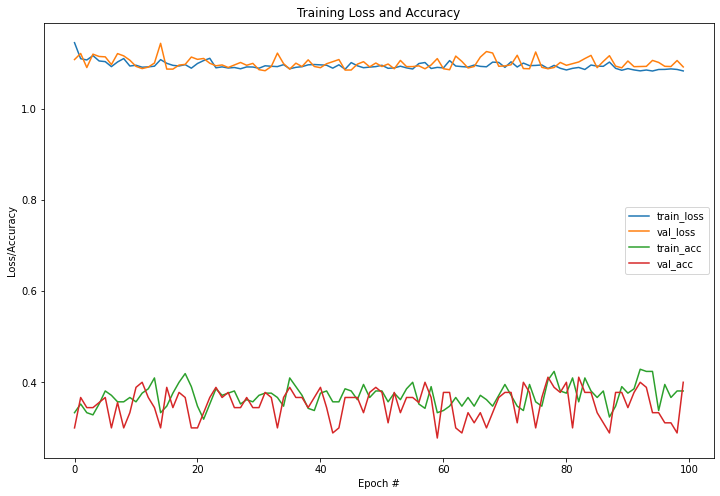

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

[Useful material](https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting) for interpreting the loss functions and accuracy functions:

*the training loss will go down either when the model learns signal or when it learns noise. But the validation loss will go down only when the model learns signal. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, but when it learns noise a gap is created in the curves. The size of the gap tells you how much noise the model has learned.*

*Underfitting the training set is when the loss is not as low as it could be because the model hasn't learned enough signal. Overfitting the training set is when the loss is not as low as it could be because the model learned too much noise. The trick to training deep learning models is finding the best balance between the two.*



Normalized confusion matrix
[[21  0 11]
 [15  2 14]
 [14  0 13]]


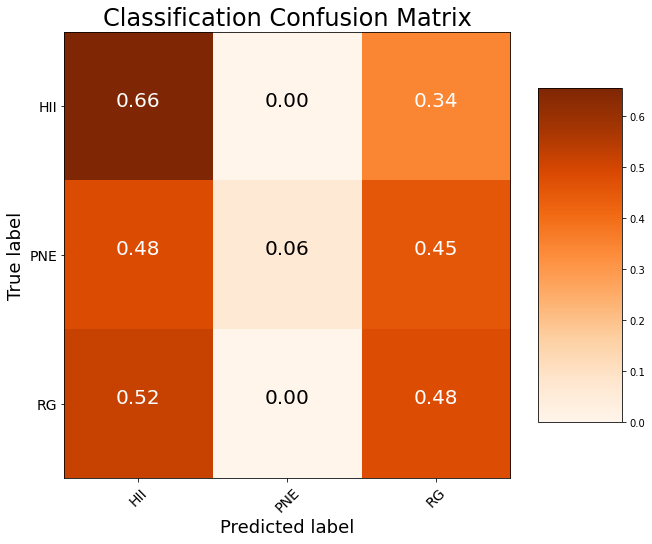

In [ ]:
predictions_cm = np.argmax(predictionsANN,axis=1)

cmatrix = confusion_matrix(testLabels.argmax(axis=1), predictions_cm)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

### Removing the momentum parameter from the optimiser:

In [ ]:
model = Sequential() #Sequential is the model, so defining it in a variable so we can use it later.

model.add(Dense(256, input_shape=(32761,), activation="sigmoid"))
#Sigmoid activates the layer.
#first parameter of Dense() is the nodes, we used these numbers in the lectorial. Second parameter is the shape of the image

model.add(Dense(128, activation="sigmoid"))#hidden layer

model.add(Dense(3, activation="softmax"))#first parameter is how many classifications we have. 
#we have three layers, one input layer, one hidden layer and one output layer. 


# ----------------------------------------

learnRate = 0.01 #one of the most important parameters to set in the model. 
#learnRate is for determining how much to change a weight to drive the loss function to a minimum. 
#higher it's set = faster the model runs, but less accurate it is. 

opt = SGD(learnRate) #used for optimising the model. 

# ----------------------------------------

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])#compiling the model

epochs = 100 #number of runs the model does. The more epochs can cause overfit and too little epochs will be underfit. 

#applying the data to the model. 
H = model.fit(trainSet, trainLabels, validation_data=(testSet, testLabels),
              epochs=epochs, batch_size=64, verbose = 0)


#------------------------------------------
from sklearn.metrics import classification_report #prints a report of the model


#applying the model to all the test data to check how well it's performed. 
predictionsANN = model.predict(testSet)

# Print a formatted report
print(classification_report(testLabels.argmax(axis=1), 
                                                  
                            predictionsANN.argmax(axis=1), 
                            target_names=[str(x) for x in lb.classes_]))#sets the labels for each output
                                                                        



3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.39      0.62      0.48        32
         PNE       0.33      0.06      0.11        31
          RG       0.36      0.44      0.40        27

    accuracy                           0.38        90
   macro avg       0.36      0.38      0.33        90
weighted avg       0.36      0.38      0.33        90



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

#plotting the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #the required parameters for the confusion matrix function

    
#_____________________________________________________________________
# This is run only if the 'normalize' parameter is set to true.
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm) #this prints the values that would be in the confusion matrix. 

#_____________________________________________________________________
#plotting the CM
    plt.figure(figsize = (10, 10)) #figure size
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #shows the image instead of printing it
    
    plt.title(title, size = 24) #setting the title of the plot, with font size. 
    
    plt.colorbar(aspect=4) #including a colour bar
    
    tick_marks = np.arange(len(classes)) #declaring a variable for number of ticks on both axes
    
    plt.xticks(tick_marks, classes, rotation=45, size = 14) #ticks on axes with size and angle. 
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

#_____________________________________________________________________
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

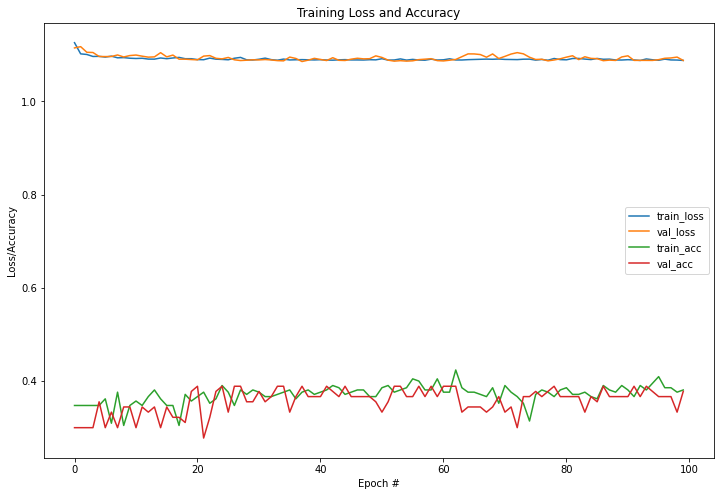

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Normalized confusion matrix
[[20  3  9]
 [17  2 12]
 [14  1 12]]


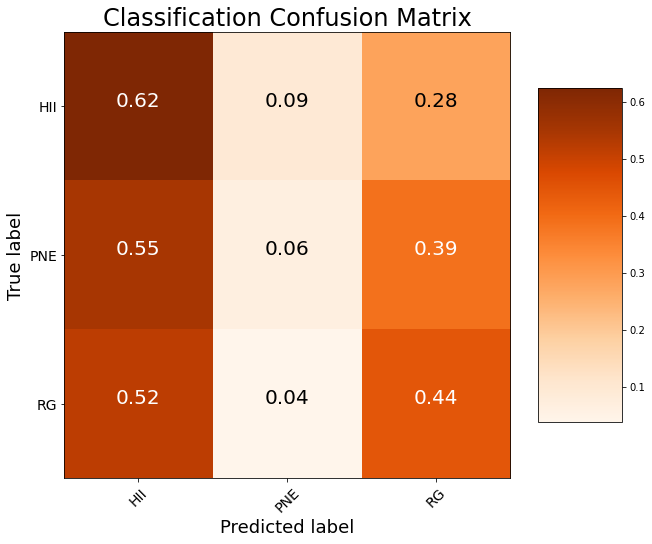

In [ ]:
predictions_cm = np.argmax(predictionsANN,axis=1)

cmatrix = confusion_matrix(testLabels.argmax(axis=1), predictions_cm)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

### Notes 

For both instances of changing the momentum value, there is high loss and low prediction values. 

Having momentum set to default smoothes the change in the loss function.

## Quantifying the performance

<font color='red'>Once your model is trained, run a few predictions using the test data and compare with the known label. Then, produce a classification report using the test data. Using the saved history from your model fit, plot on separate graphs the evolution of the Training and Testing/Validation loss and the evolution of the Training and Testing/Validation accuracy. You can also use the plotting code from [lectorial in week 8](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_8_Random_Forest.ipynb) to produce a confusion matrix to help assess the classifier. Based on the outputs of the classification report and the plots, assess the performance of the classifier.</font>

Making a function. Noting that we will only allow the following for the exploration:

- 2 times the number of layers
- 2 times the number of neurons.
- half the number of neurons.

In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(pixelValues, binarizedLabels, test_size=0.3)

In [ ]:
def annFn(extraLayers : int, neurons: float, learnRate: float, epochs: int, momentum: float):
  '''
  
  extraLayers == 0, 1 or 2

  neurons == 0.5, 1.0, 2.0


  '''

  model = Sequential()
  
  model.add(Dense(256*neurons, input_shape=(32761,), activation="sigmoid"))

  model.add(Dense(128*neurons, activation="sigmoid"))
  
  if extraLayers == 1:
    model.add(Dense(128*neurons, activation="sigmoid"))
  
  if extraLayers == 2: 
    model.add(Dense(128*neurons, activation="sigmoid"))
    model.add(Dense(128*neurons, activation="sigmoid"))

  model.add(Dense(3, activation="softmax"))

  # ----------------------------------------

  opt = SGD(learnRate, momentum = momentum)

  # ----------------------------------------

  model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

  H = model.fit(trainData, trainLabels, validation_data=(testData, testLabels),
                epochs= epochs, batch_size=64, verbose = 0)

  predictions = model.predict(testData)
  # print(predictions)
  print(classification_report(testLabels.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in lb.classes_]))

  def lossAccHistory(H):
      fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8)) # Subplots

      # Loss function curves against the number of epochs:
      ax1.plot(np.arange(0, epochs), H["loss"], label="train_loss")
      ax1.plot(np.arange(0, epochs), H["val_loss"], label="val_loss")
      ax1.title.set_text('Training and Validation Loss')
      ax1.set_xlabel('Epoch Number')
      ax1.set_ylabel('Loss')
      ax1.legend(loc='best')

      # Accuracy curves against the number of epochs:
      ax2.plot(np.arange(0, epochs), H["accuracy"], label="train_acc")
      ax2.plot(np.arange(0, epochs), H["val_accuracy"], label="val_acc")
      ax2.title.set_text('Training and Validation Accuracy')
      ax2.set_xlabel('Epoch Number')
      ax2.set_ylabel('Accuracy')
      ax2.legend(loc='best')

  lossAccHistory(H.history)


  testY = np.argmax(testLabels,axis=1)
  predictY = np.argmax(predictions, axis=1)

  cm = confusion_matrix(testY, predictY)
  #call the function above that makes the plot, with given matrix and the labels required
  plot_confusion_matrix(cm, normalize=True,classes = ['HII', 'PNE', 'RG'],
                        title = 'Confusion Matrix')

Using the same hyperparameters as before to ensure the function works.

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       1.00      0.56      0.72        32
         PNE       0.37      0.77      0.50        22
          RG       0.77      0.56      0.65        36

    accuracy                           0.61        90
   macro avg       0.71      0.63      0.62        90
weighted avg       0.75      0.61      0.64        90

Normalized confusion matrix


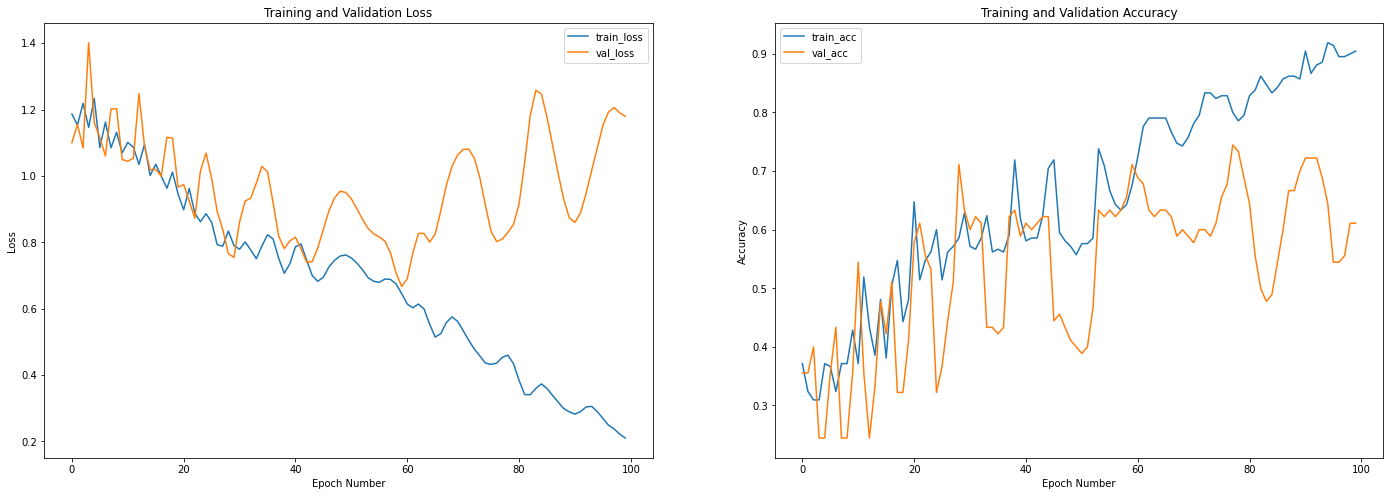

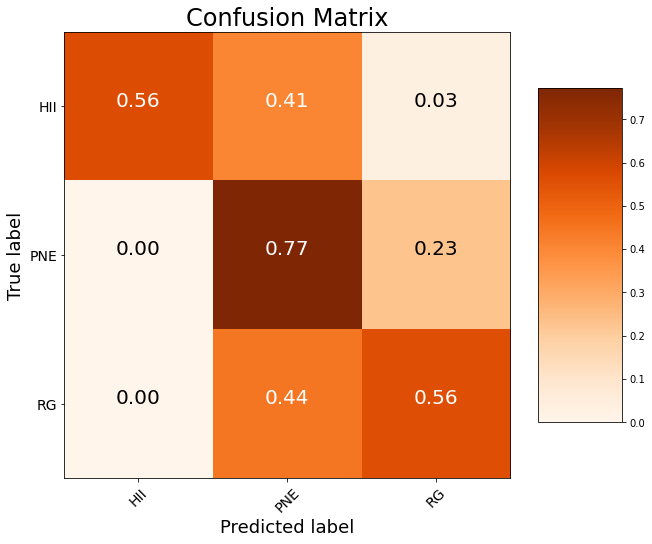

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 1.0)

## Tweak the hyperparameters to improve performance
<font color='red'>


Try to improve your classifier by changing the following:

- The learning rate and number of epochs (smaller learning rate generally requires more training epochs and vice versa).
- The number of hidden layers (only try 1-2 fewer/more).
- The number of neurons in the layers (again, only try 1-2 different values).

For each tweak, run the classification reports, generate a confusion matrix, and produce plots of the history of the Loss and Accuracy and give a brief assessment of the performance. 

Finally, give a summary report for the best classifier achieved, and outline which of the changes was the most effective.</font>

### Tweaking learn rate, number of epochs and momentum

Performing the following (epochs, learn rate, momentum): 

Round 1
- 100, 0.01, 1.0
- 100, 0.005, 1.0
- 100, 0.005, 0.9
- 100, 0.01, 0.9

then round 2
- 200, 0.01, 1.0
- 200, 0.005, 1.0
- 200, 0.005, 0.9
- 200. 0.01, 0.9

then round 3
- 600, 0.01, 1.0
- 600, 0.005, 1.0
- 600, 0.005, 0.9 
- 600, 0.01, 0.9

#### Round 1

*Error with prediction of certain objects due to low number of epochs (only sometimes?).*

*Decreasing learn rate prevented overfitting (loss and accuracy functions converge)*

*Decreasing momentum reduced fluctuation in loss function*

*The final tweak in this round saw the best results. Convergence between the loss functions, best minimisation of the loss functions and highest accuracies with no divergence. Predictions for this tweak had acceptable results for HII and RG, ~0.5 for PNE.*

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       1.00      0.53      0.69        32
         PNE       0.39      0.59      0.47        22
          RG       0.72      0.81      0.76        36

    accuracy                           0.66        90
   macro avg       0.71      0.64      0.64        90
weighted avg       0.74      0.66      0.67        90

Normalized confusion matrix


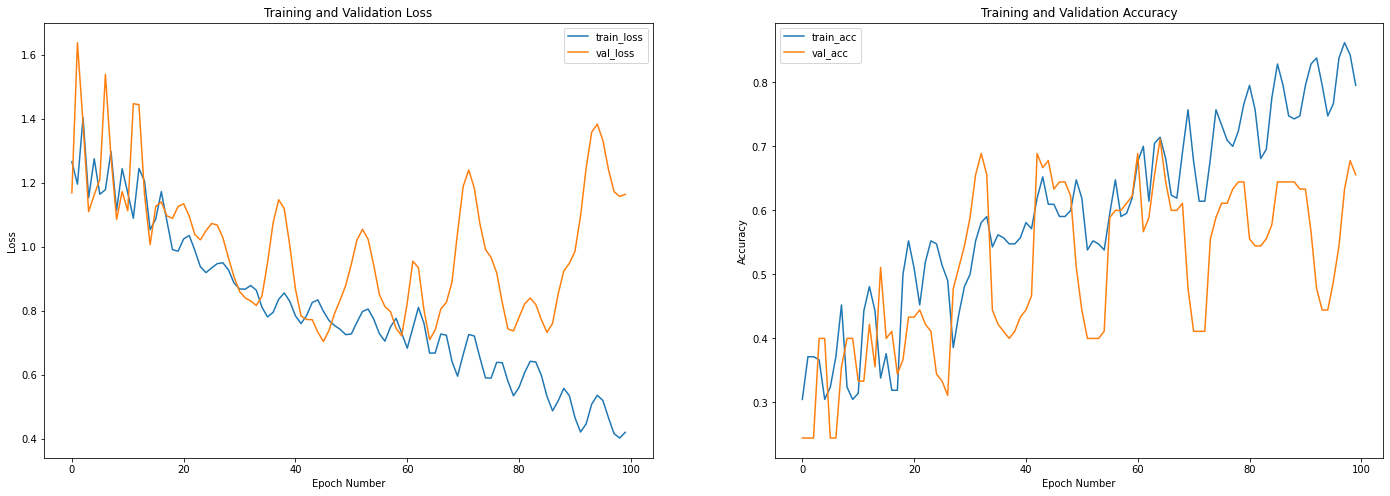

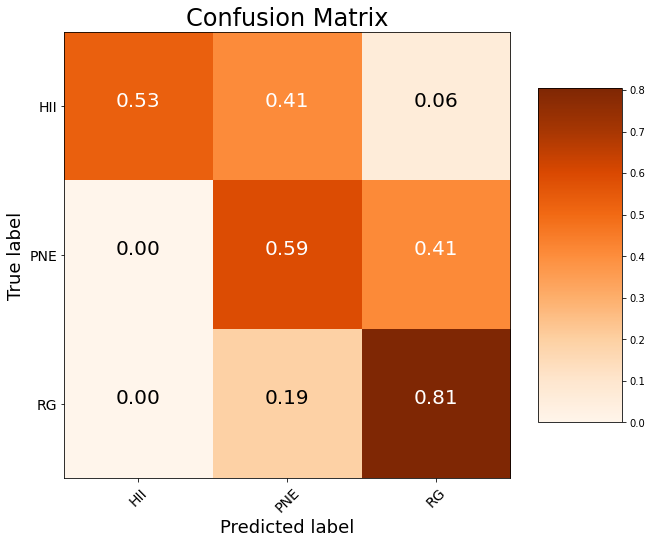

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 1.0)

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.91      0.62      0.74        32
         PNE       0.32      0.77      0.45        22
          RG       0.73      0.31      0.43        36

    accuracy                           0.53        90
   macro avg       0.65      0.57      0.54        90
weighted avg       0.69      0.53      0.55        90

Normalized confusion matrix


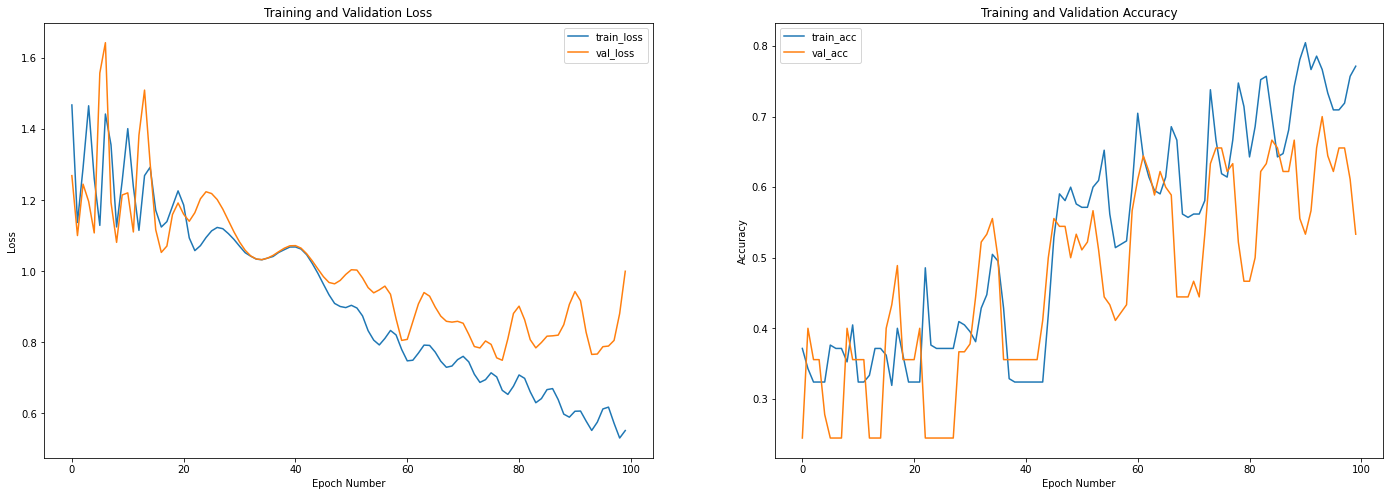

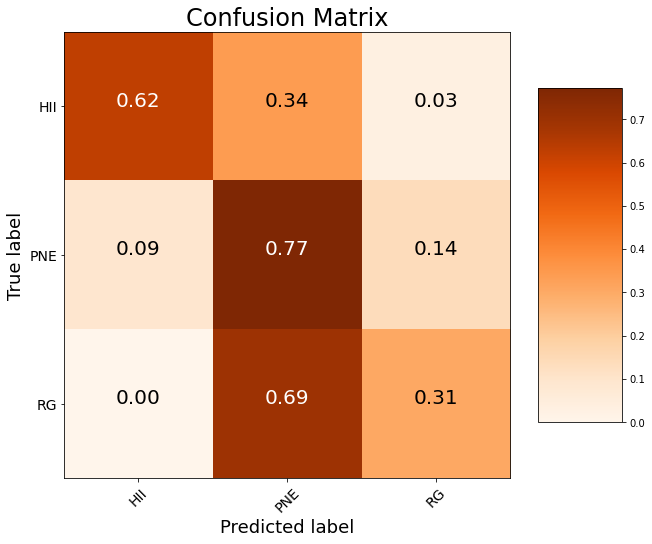

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 100, momentum = 1.0)

3/3 [==============================] - 0s 5ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         HII       0.88      0.47      0.61        32
         PNE       0.27      0.91      0.42        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.39        90
   macro avg       0.39      0.46      0.34        90
weighted avg       0.38      0.39      0.32        90

Normalized confusion matrix


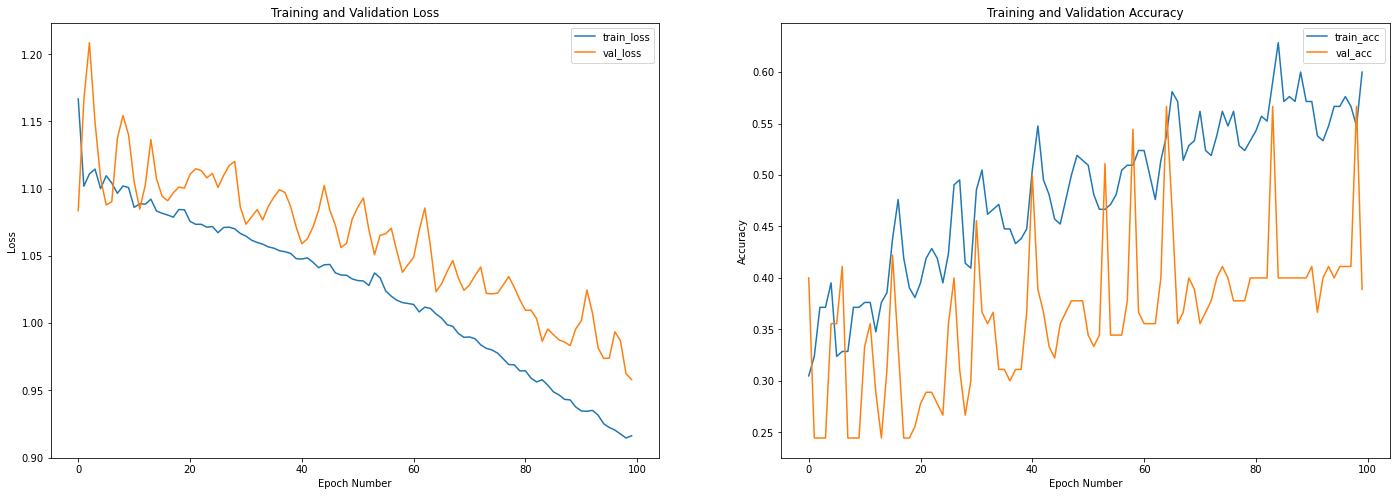

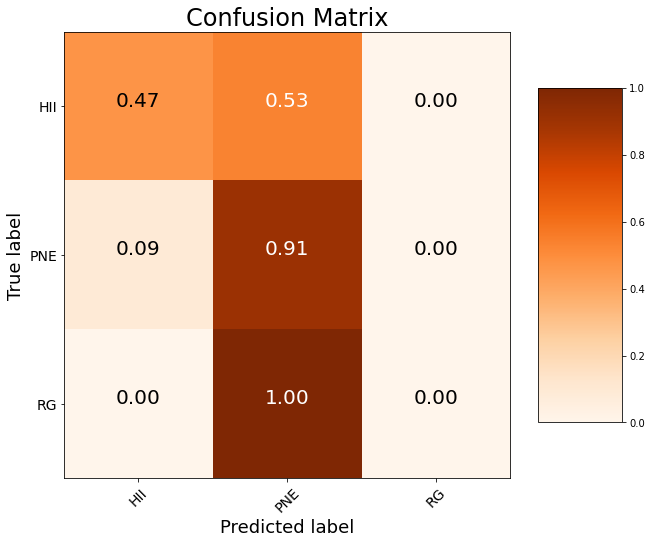

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.95      0.56      0.71        32
         PNE       0.30      0.95      0.45        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.43        90
   macro avg       0.41      0.51      0.39        90
weighted avg       0.41      0.43      0.36        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


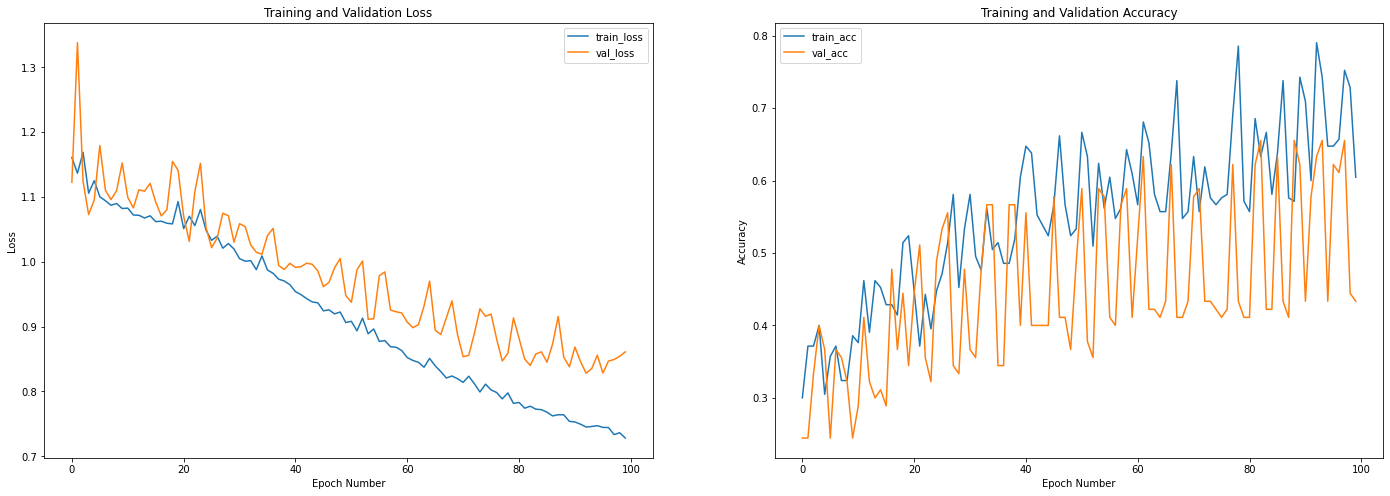

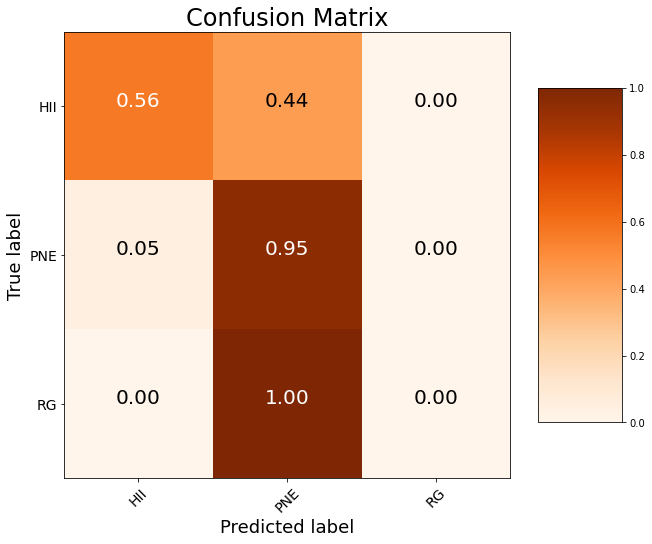

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

####  Round 2

*Similar to round 1, decreasing learn rate and momentum reduced fluctation in the loss functions and prevented divergence between the loss functions.*

*In this round, all these tweaks cause overfitting around 100 epochs. 200 epochs is not an option.*

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.92      0.72      0.81        32
         PNE       0.56      0.64      0.60        22
          RG       0.80      0.89      0.84        36

    accuracy                           0.77        90
   macro avg       0.76      0.75      0.75        90
weighted avg       0.78      0.77      0.77        90

Normalized confusion matrix


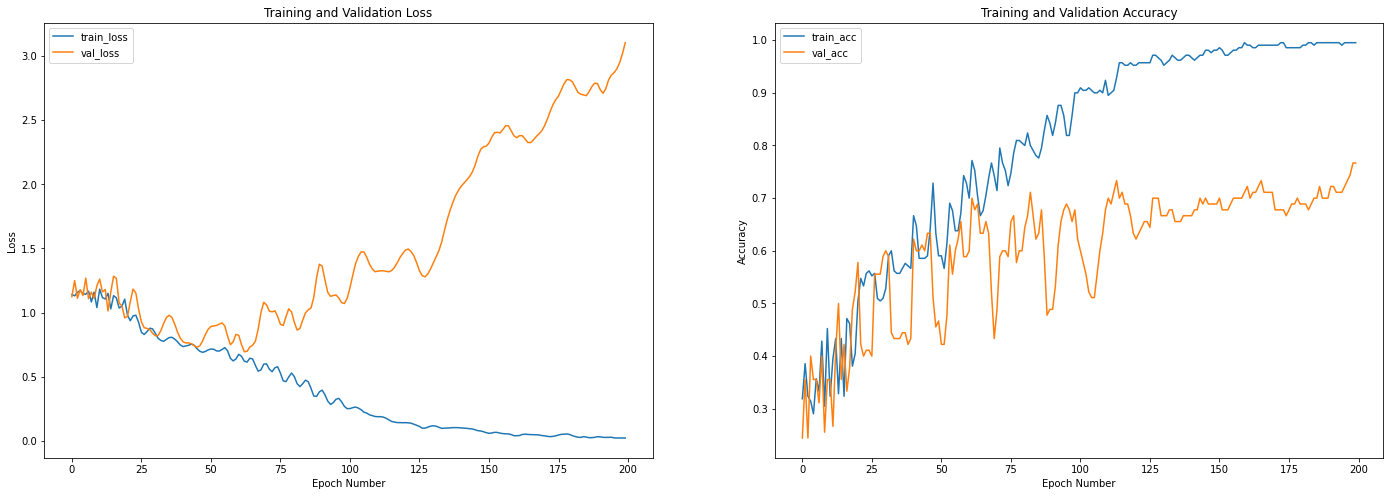

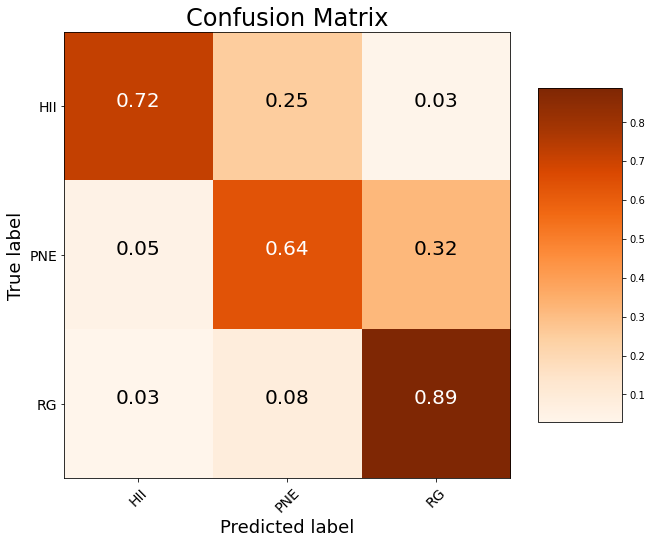

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 200, momentum = 1.0)

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.91      0.62      0.74        32
         PNE       0.53      0.73      0.62        22
          RG       0.79      0.83      0.81        36

    accuracy                           0.73        90
   macro avg       0.74      0.73      0.72        90
weighted avg       0.77      0.73      0.74        90

Normalized confusion matrix


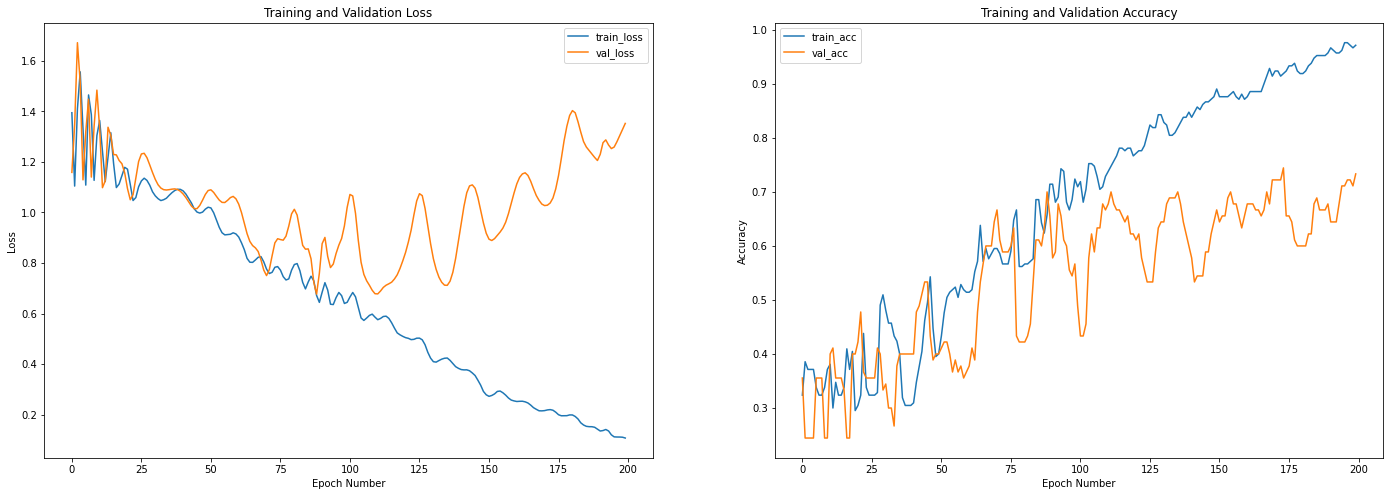

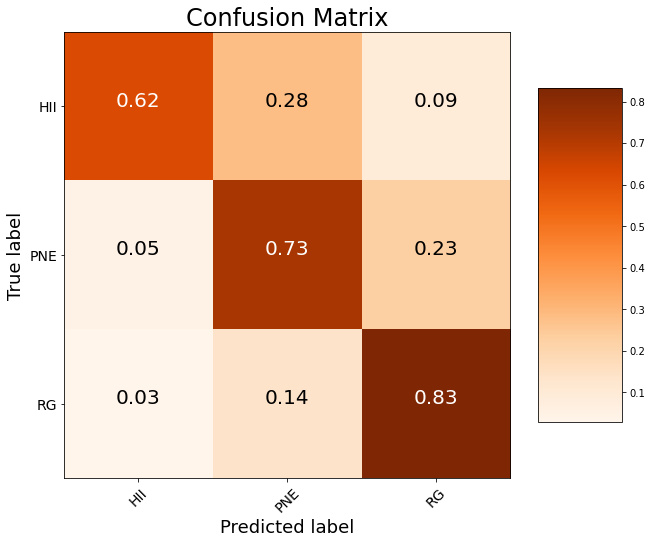

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 200, momentum = 1.0)

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       1.00      0.53      0.69        32
         PNE       0.34      0.95      0.50        22
          RG       0.91      0.28      0.43        36

    accuracy                           0.53        90
   macro avg       0.75      0.59      0.54        90
weighted avg       0.80      0.53      0.54        90

Normalized confusion matrix


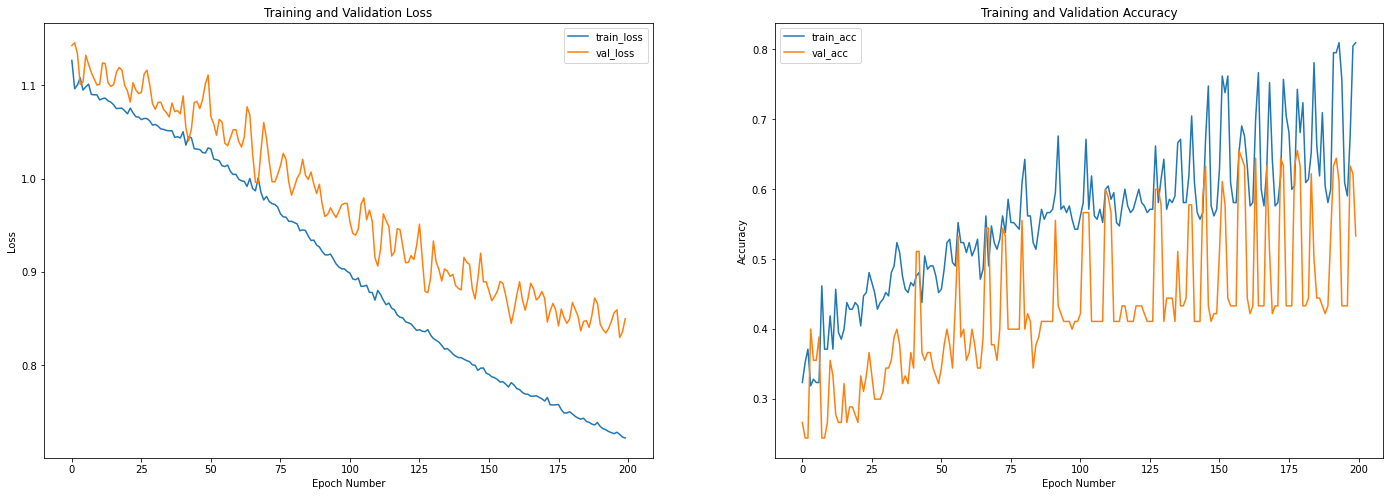

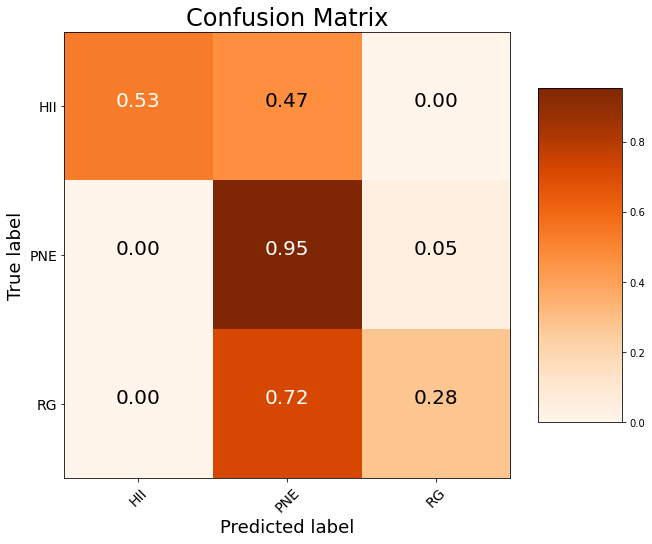

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 200, momentum = 0.9)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       1.00      0.50      0.67        32
         PNE       0.36      0.68      0.47        22
          RG       0.75      0.67      0.71        36

    accuracy                           0.61        90
   macro avg       0.70      0.62      0.61        90
weighted avg       0.74      0.61      0.63        90

Normalized confusion matrix


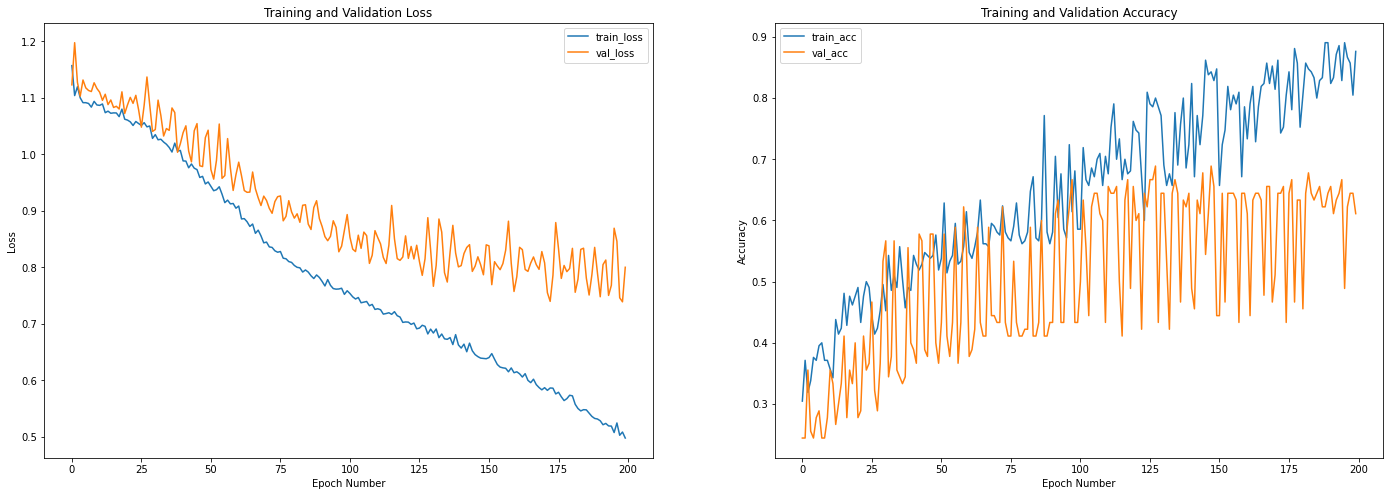

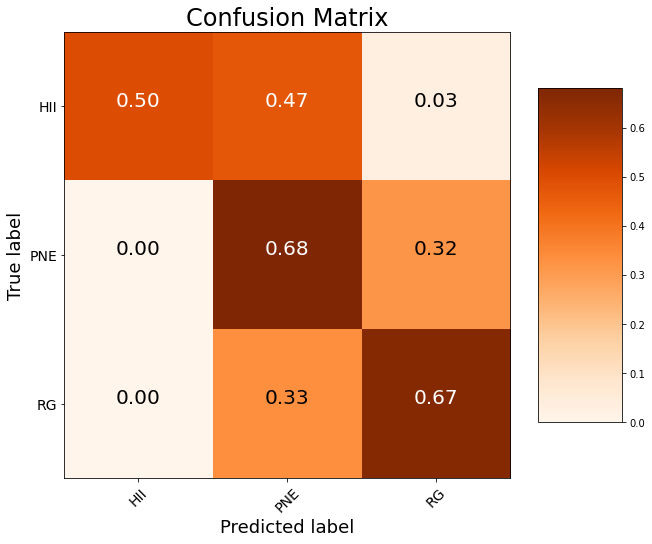

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 200, momentum = 0.9)

#### Round 3
*All tweaks in this round had poor results. Primarily due to overfitting occuring after 100 epochs.*

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.95      0.66      0.78        32
         PNE       0.31      0.95      0.47        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.47        90
   macro avg       0.42      0.54      0.41        90
weighted avg       0.41      0.47      0.39        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


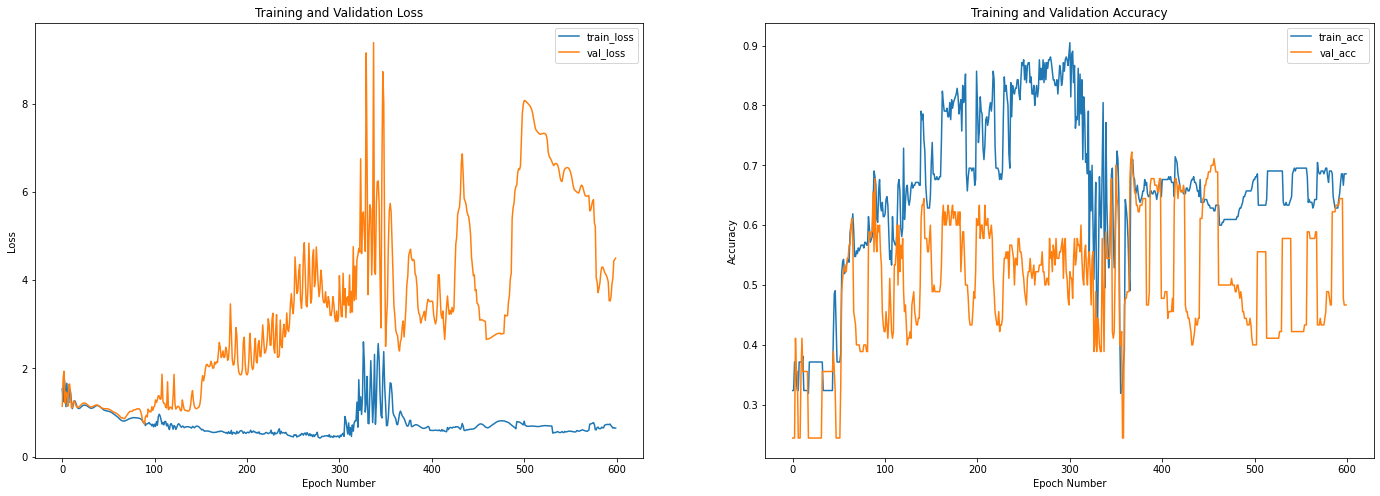

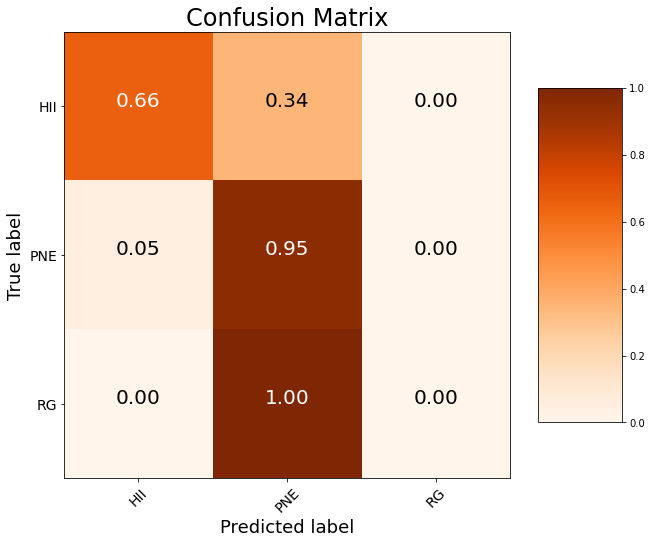

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 600, momentum = 1.0)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.74      0.78      0.76        32
         PNE       0.35      0.50      0.42        22
          RG       0.60      0.42      0.49        36

    accuracy                           0.57        90
   macro avg       0.56      0.57      0.55        90
weighted avg       0.59      0.57      0.57        90

Normalized confusion matrix


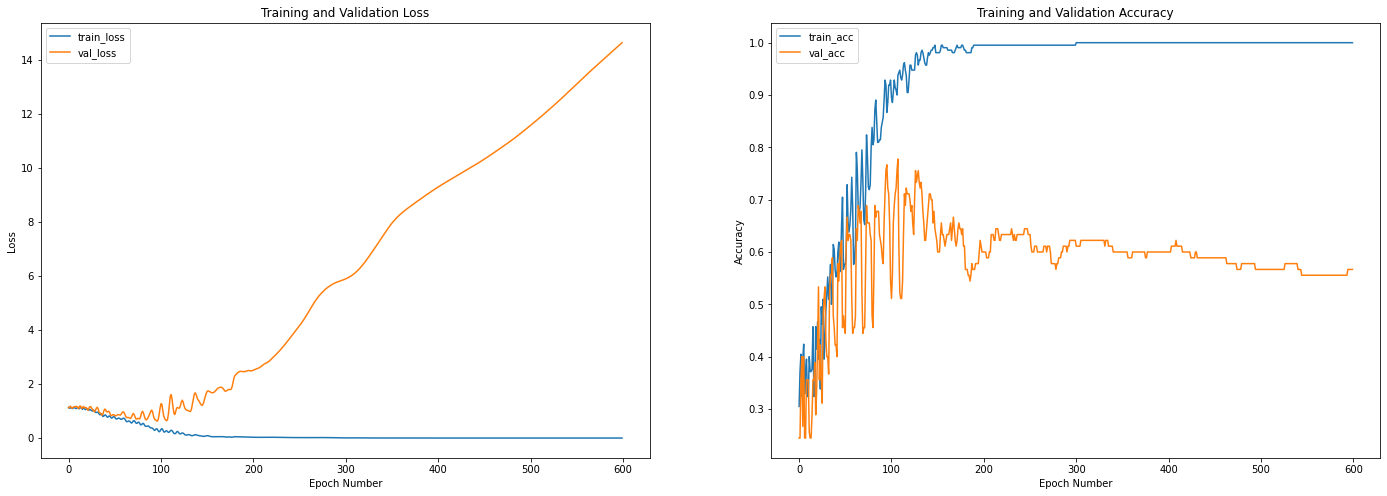

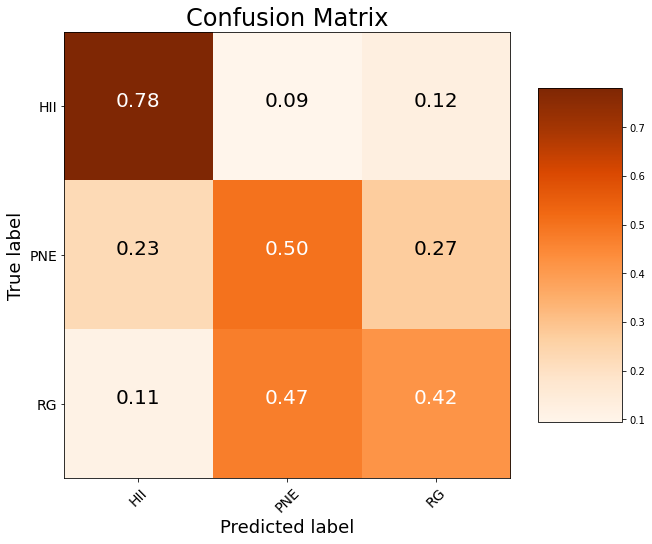

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 600, momentum = 1.0)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.95      0.59      0.73        32
         PNE       0.45      0.77      0.57        22
          RG       0.84      0.75      0.79        36

    accuracy                           0.70        90
   macro avg       0.75      0.71      0.70        90
weighted avg       0.78      0.70      0.72        90

Normalized confusion matrix


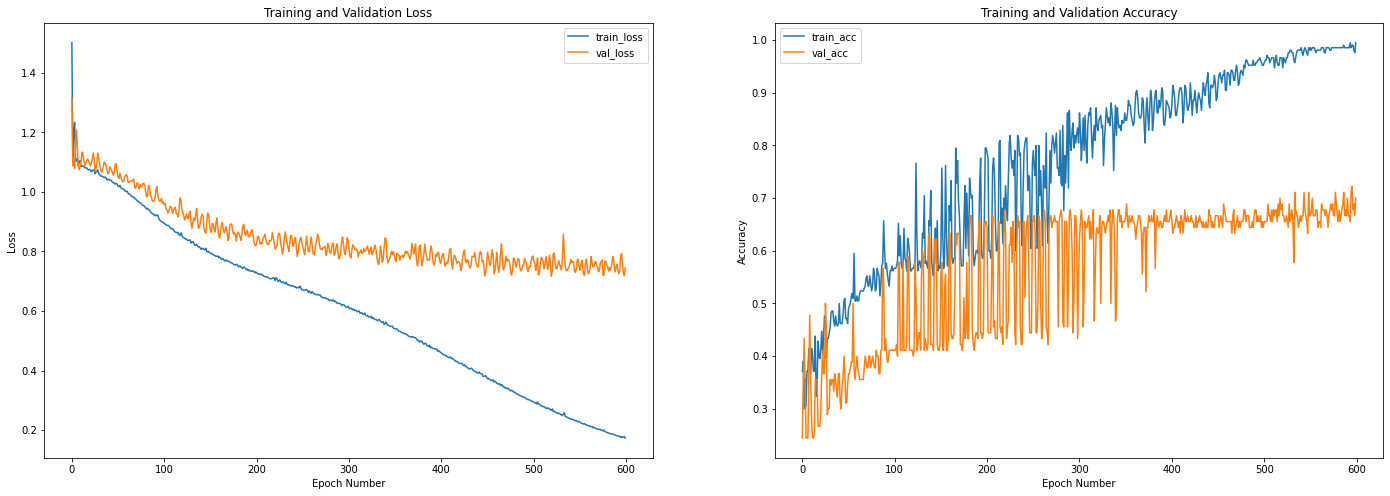

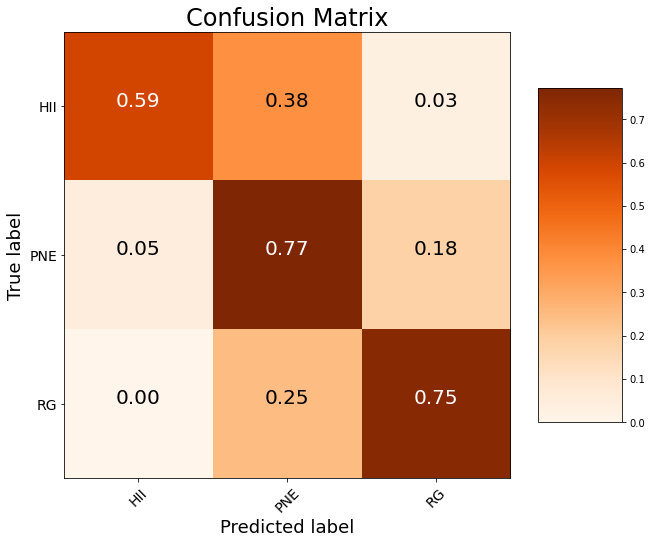

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.005, epochs = 600, momentum = 0.9)

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.90      0.59      0.72        32
         PNE       0.42      0.64      0.51        22
          RG       0.78      0.78      0.78        36

    accuracy                           0.68        90
   macro avg       0.70      0.67      0.67        90
weighted avg       0.74      0.68      0.69        90

Normalized confusion matrix


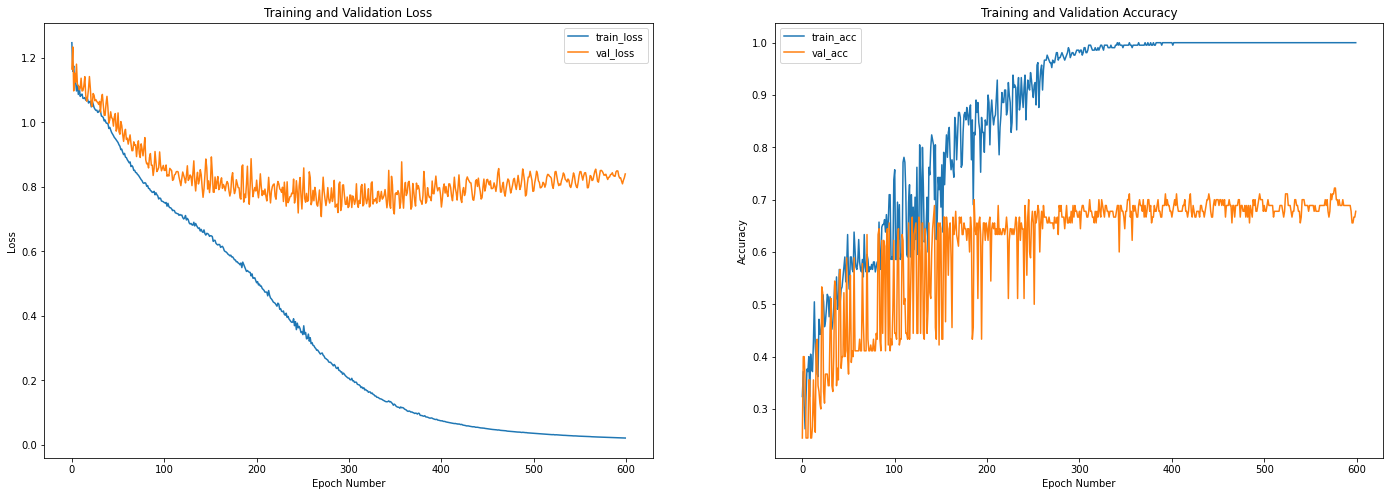

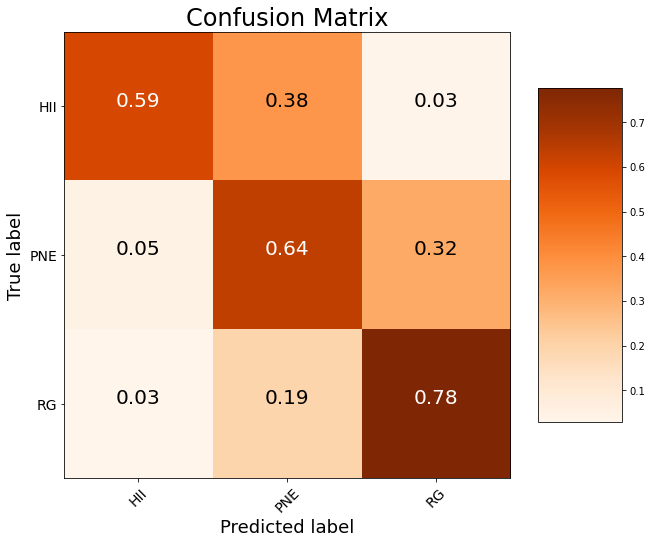

In [ ]:
annFn(extraLayers = 0, neurons = 1.0, learnRate = 0.01, epochs = 600, momentum = 0.9)

### Tweaking the number of layers and neurons based on the best performance from the previous rounds.

Should we perform the same number of tweaks in the previous rounds for the new 
number of layers and neurons?

You may perform this process, however there will be many more rounds as it would be a more thorough approach to find the best hyperparameters. 

Performing the following with 100 epochs, 0.01 learning rate, 0.9 momentum: 

Round 4

- 1 extra layer, default neurons (1.0)
- 1 extra layer, double neurons
- 1 extra layer, half the neurons

Round 5
- 2 extra layers, default neurons
- 2 extra layers, double neurons
- 2 extra layers, half neurons

#### Round 4
*Overall poor performance, loss functions converge but low minimisation achieved. Some predictions missing for objects.*

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

         HII       0.50      0.19      0.27        32
         PNE       0.24      0.86      0.38        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.28        90
   macro avg       0.25      0.35      0.22        90
weighted avg       0.24      0.28      0.19        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


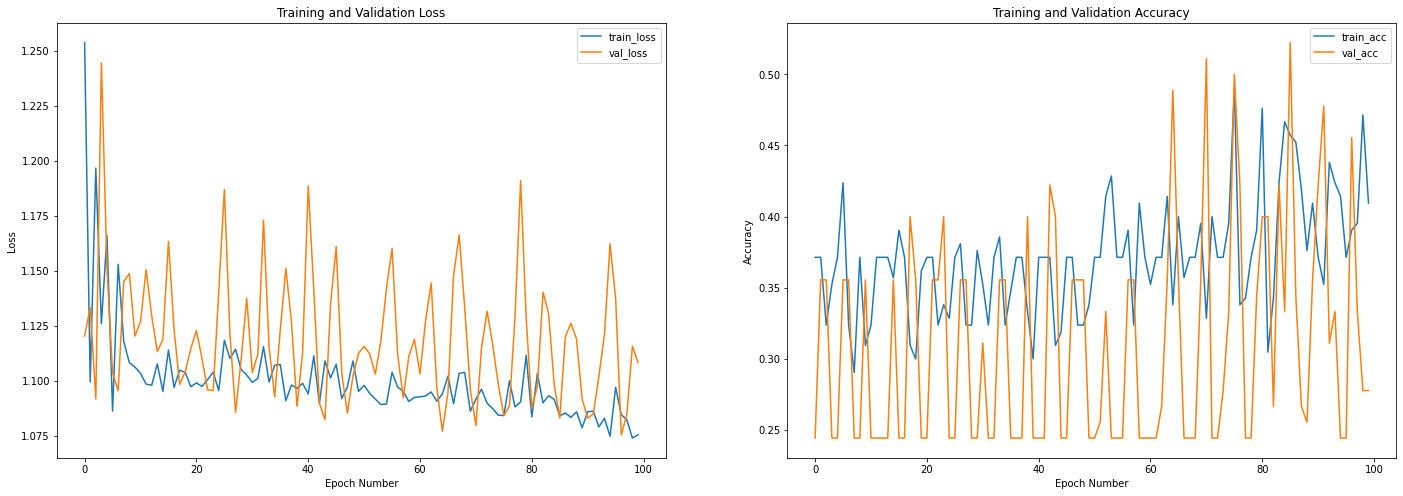

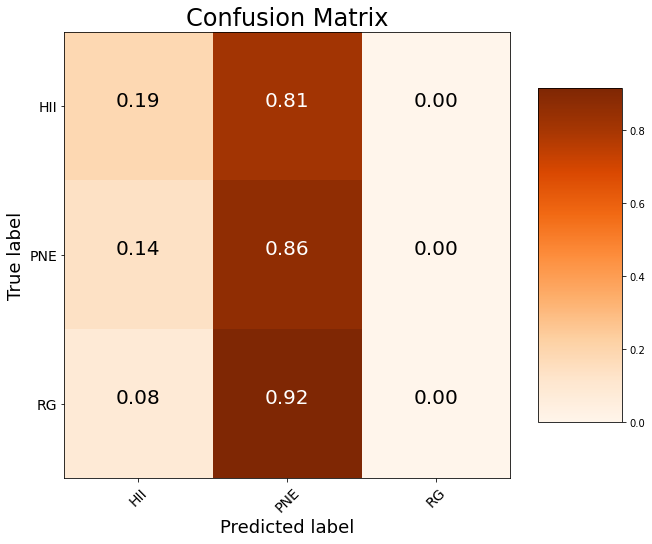

In [ ]:
annFn(extraLayers = 1, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       1.00      0.16      0.27        32
         PNE       0.26      1.00      0.41        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.30        90
   macro avg       0.42      0.39      0.23        90
weighted avg       0.42      0.30      0.20        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


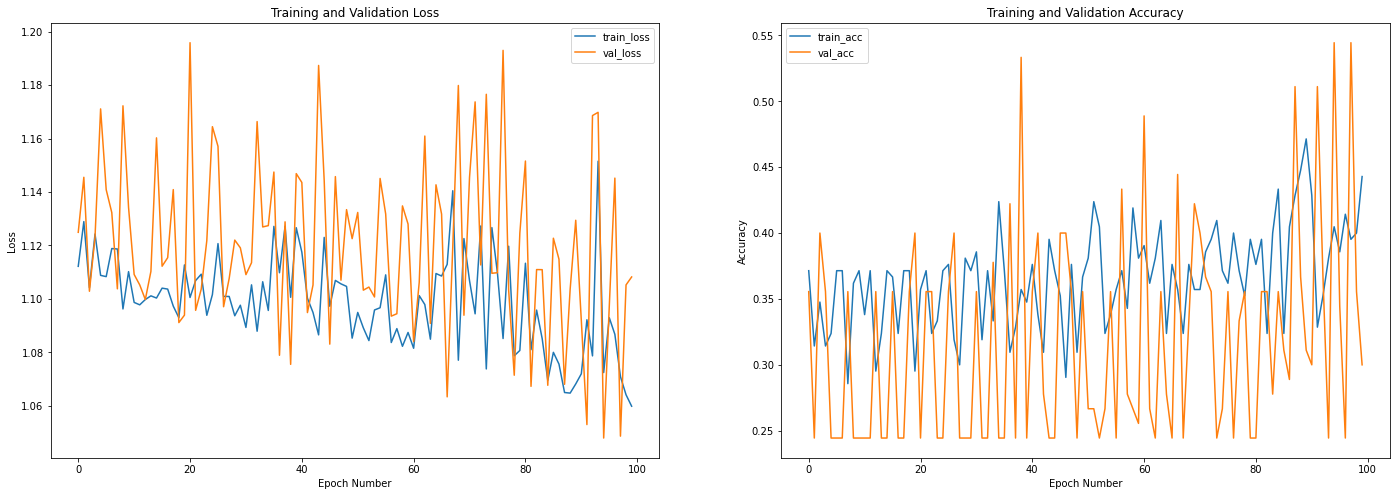

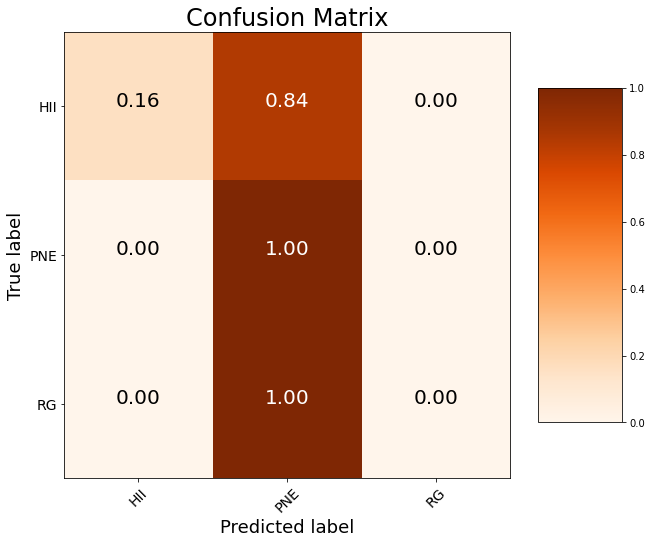

In [ ]:
annFn(extraLayers = 1, neurons = 2.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.63      0.59      0.61        32
         PNE       0.27      0.73      0.39        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.39        90
   macro avg       0.30      0.44      0.33        90
weighted avg       0.29      0.39      0.31        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


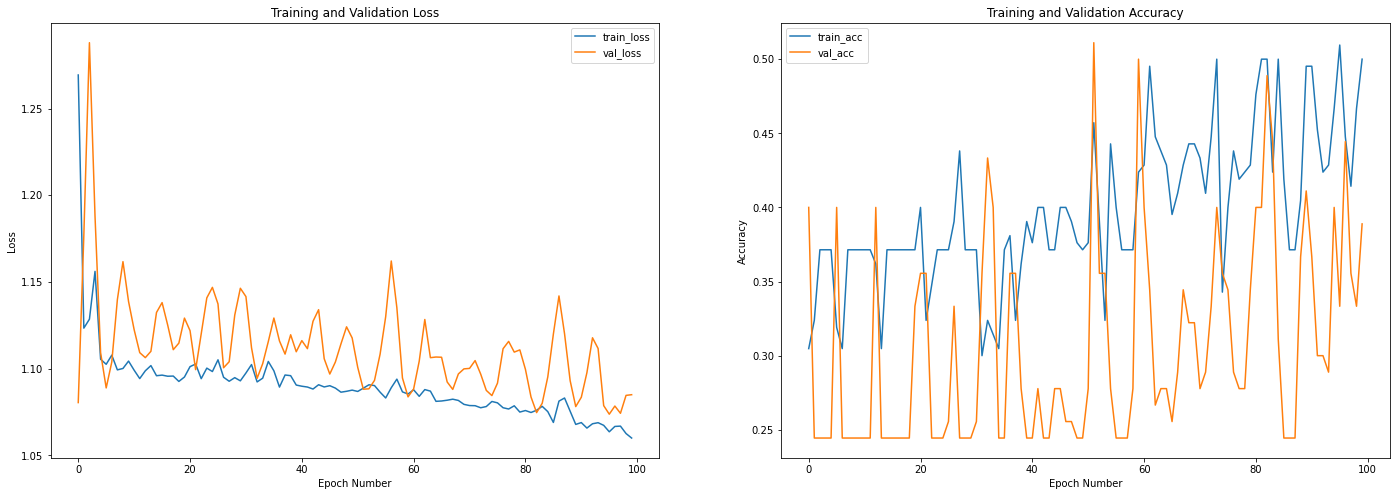

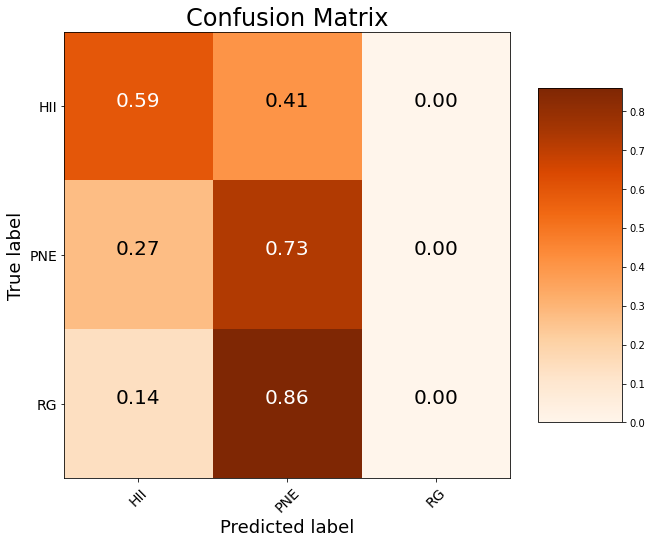

In [ ]:
annFn(extraLayers = 1, neurons = 0.5, learnRate = 0.01, epochs = 100, momentum = 0.9)

#### Round 5
*Same as round 4, overall poor performance.*

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         HII       0.00      0.00      0.00        32
         PNE       0.24      1.00      0.39        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.24        90
   macro avg       0.08      0.33      0.13        90
weighted avg       0.06      0.24      0.10        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


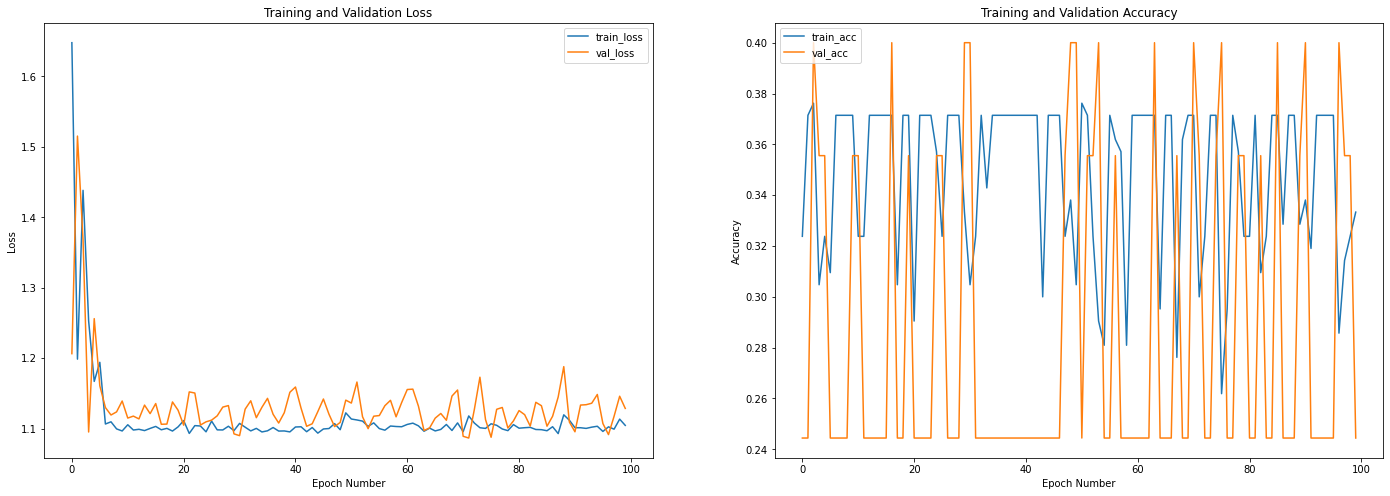

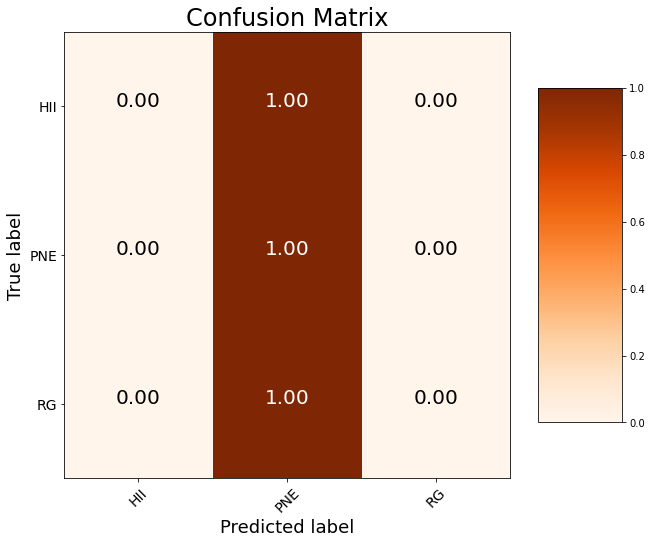

In [ ]:
annFn(extraLayers = 2, neurons = 1.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         HII       0.00      0.00      0.00        32
         PNE       0.24      1.00      0.39        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.24        90
   macro avg       0.08      0.33      0.13        90
weighted avg       0.06      0.24      0.10        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


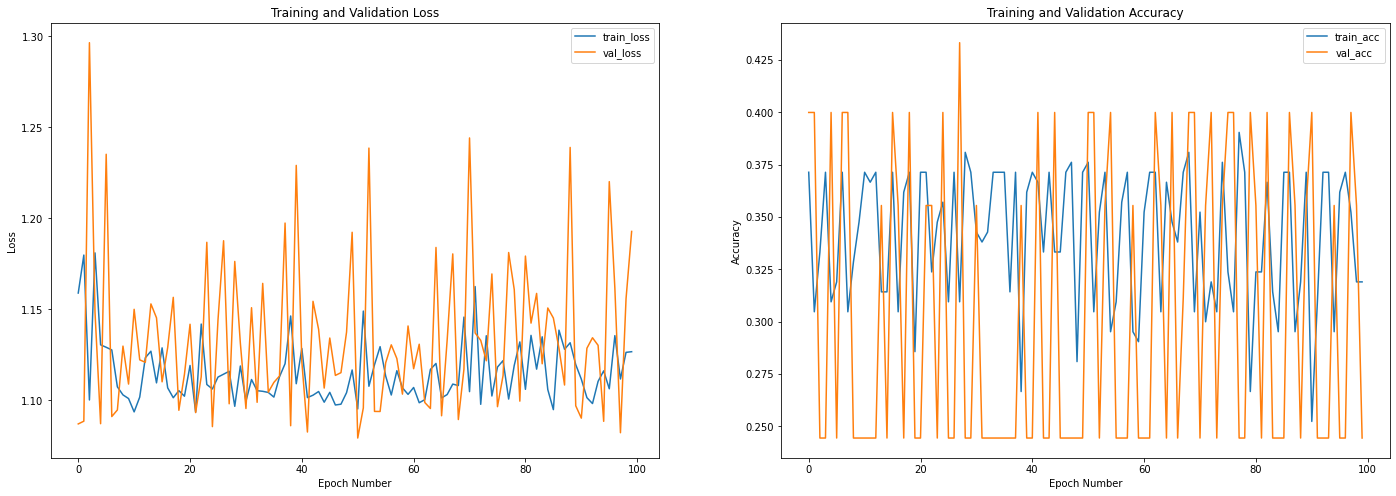

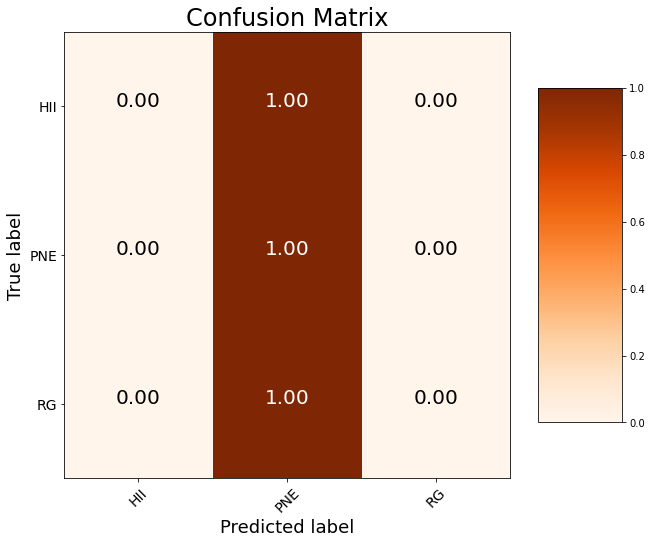

In [ ]:
annFn(extraLayers = 2, neurons = 2.0, learnRate = 0.01, epochs = 100, momentum = 0.9)

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         HII       0.00      0.00      0.00        32
         PNE       0.24      1.00      0.39        22
          RG       0.00      0.00      0.00        36

    accuracy                           0.24        90
   macro avg       0.08      0.33      0.13        90
weighted avg       0.06      0.24      0.10        90

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


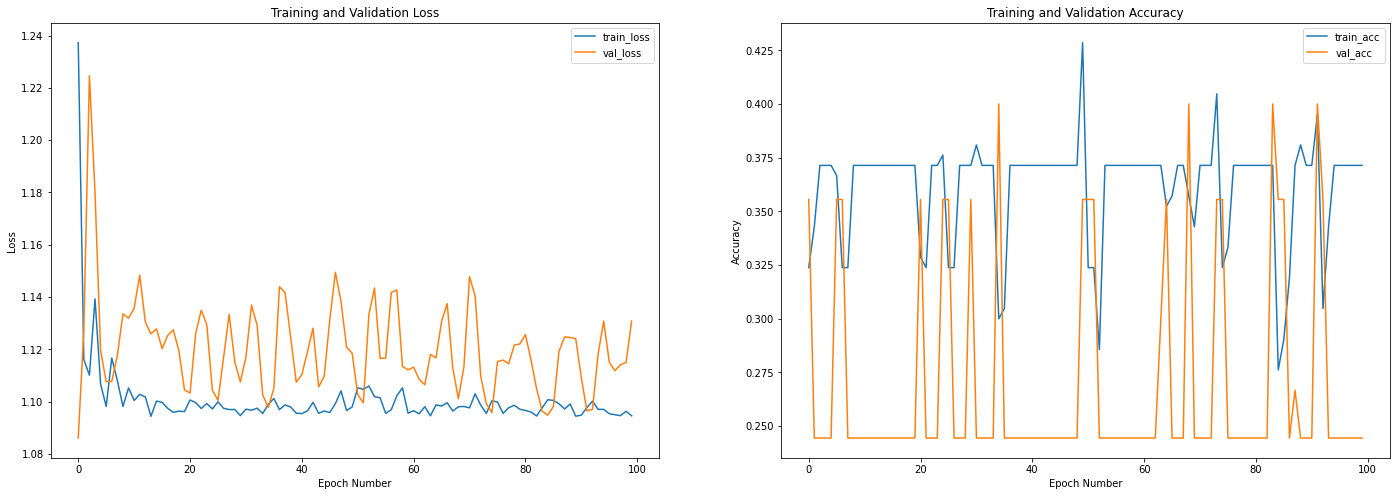

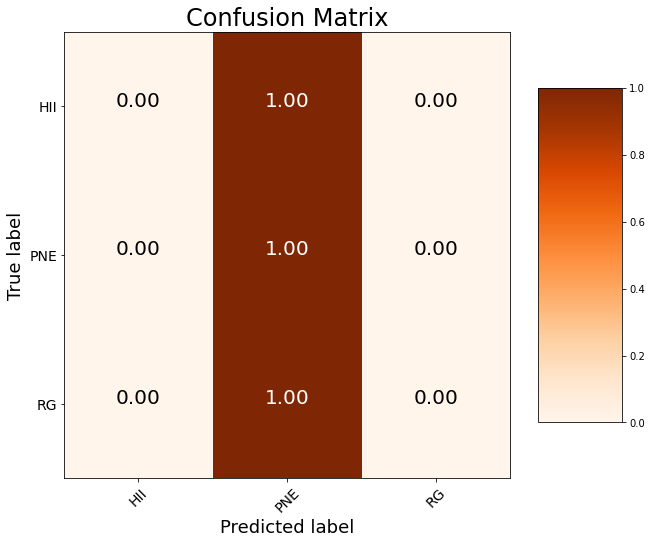

In [ ]:
annFn(extraLayers = 2, neurons = 0.5, learnRate = 0.01, epochs = 100, momentum = 0.9)

### Final remarks

Considering how the loss functions in all the round 4 tweaks (not the round 5) show convergence and consistent decrease, we could try increasing the number of epochs as I mentioned in the begining of this subsection to see how the model performs with the one extra layer. However, for now we will continue to the CNN model. 

# Part 2: Convolutional Neural Networks

In this part, you will build a classifier for the same dataset, but now using all three Spitzer bands (I2 = 4.5 $\mu$m, I3 = 5.8 $\mu$m, I4 = 8 $\mu$m) as input to a CNN. 


## Preparing the data


As input, CNNs take a 4D array of images with shape (N_source, N_pix, N_pix, N_channel), where  N_source is the number of sources in your batch of data, N_pix is the number of pixels (can be different for width/height), and N_channel is the number of different colour images available per source (this could be RGB channels for standard images, but here it is the 3 Spitzer bands). As for the ANNs, we also require labels that have been binarized. You need to write a function similar to the one used to manipulate the data for the ANN, but modified to produce the desired input for the CNN:
- For each source, read and then resize the I2, I3, and I4 images. Stack to form an array with shape (N_pix, N_pix, N_channel).
- Normalise each image in the stack, but here we'd like to maintain the colour differences. So, determine the maximum  across all 3 images and use that as your nomalisation factor for all three images.

In a similar fashion to Part 1, you will need to loop over each source, read in the images, and save to a 4D array with shape (N_source, N_pix, N_pix, N_Channel).  Again, you will require a vector containing the labels for each source, as well as the binarized version. 

Once you have the array containing the images and the labels, split your data into a training and test/validation set.
</font>

in the lectorial, we had colours has RGB, but here we have different wavelengths of IR

CNN take array of shape: [N_source, N_pix, N_pix, N_channel]

In [ ]:
def cnnPrepFn(directory, source_type, zoom_factor):
  # Similar initial process as the ANN function:
  files = glob.glob(root + data + '/' + source_type+'/'+'*_I4.fits')
  # The amount of zooming for the images will impact the image's dimensions.
  # Since 302x302 is the original size of the images, we want the dimension of the zoomed-in images which depends on the zoom factor.
  imagesArr = np.zeros((100,int(zoom_factor*302),int(zoom_factor*302),3)) 
  labelsList = [] # The labels will become a 1D array.

  # Identifying the 3 images that will be resized and normalised:
  for indx in np.arange(0,len(files)):
    source = files[indx].split('_I4.fits')[0] # Finding the name for each source by splitting the string from `glob.glob` into two parts.
                                              # We don't want the text starting from _, so we use [0] to get the source name only.
    i2Image = fits.getdata(source+'_I2.fits') # The I2 image for the source.
    i3Image = fits.getdata(source+'_I3.fits') # The I3 image for the source.
    i4Image = fits.getdata(source+'_I4.fits') # The I4 image for the source.

    # Resizing the three Spitzer-band images above and finding the maximum value in each image:
    resizeI2 = ndimage.zoom(i2Image, zoom=zoom_factor)
    resizeI2Max = np.max(resizeI2)
    resizeI3 = ndimage.zoom(i3Image, zoom=zoom_factor)
    resizeI3Max = np.max(resizeI3)
    resizeI4 = ndimage.zoom(i4Image, zoom=zoom_factor)
    resizeI4Max = np.max(resizeI4)

    # Normalisation is done by finding the greatest value in the maxima for each of the 3 images.
    # This is so all the values are smaller than or equal to 1 (for the CNN), and maintain the colour differences between them.
    normFactor = np.max([resizeI2Max, resizeI3Max, resizeI4Max])

    # Applying the normalisation factor to the resized images:
    normI2 = resizeI2/normFactor
    normI3 = resizeI3/normFactor 
    normI4 = resizeI4/normFactor

    # Adding the resized and normalised images into the iamge array:
    imagesArr[indx,:,:,0] = normI2
    imagesArr[indx,:,:,1] = normI3
    imagesArr[indx,:,:,2] = normI4

    # Adding the label that identifies the source type (HII, PNE, RG):
    labelsList.append(source_type)

  # Converting the list of labels into an array:
  labelsArr = np.array(labelsList)

  return imagesArr, labelsArr

In [ ]:
# Using the same zoom factor as last time:
HII_Images, HII_Labels = cnnPrepFn(dir, "HII", zoom_factor=0.6)
PNE_Images, PNE_Labels = cnnPrepFn(dir, "PNE", zoom_factor=0.6)
RG_Images, RG_Labels = cnnPrepFn(dir, "RG", zoom_factor=0.6)

In [ ]:
combinedImages = np.concatenate((HII_Images, PNE_Images, RG_Images), axis=0)
combinedLabels = np.concatenate((HII_Labels, PNE_Labels, RG_Labels),axis=0)

# Checking the dimensions of the arrays:
print(combinedImages.shape)
print(combinedLabels.shape)
print(combinedLabels[0], combinedLabels[100], combinedLabels[200]) # Checking the labels have been combined correctly.

# Binarising the labels for the CNN:
lb = LabelBinarizer()
combinedLabels = lb.fit_transform(combinedLabels)

# Checking the dimensions and form of the binarised vectors:
print(combinedLabels.shape)
print(combinedLabels[0], combinedLabels[100], combinedLabels[200])

(300, 181, 181, 3)
(300,)
HII PNE RG
(300, 3)
[1 0 0] [0 1 0] [0 0 1]


for each colour, there are 100 files in each object, there are 3 objects. Totalling 900 files for all 3 colours and all objects. 

Don't have to reshape it like in the ANN section because we want to keep the colours separate.

Recalling the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

#plotting the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #the required parameters for the confusion matrix function

    
#_____________________________________________________________________
# This is run only if the 'normalize' parameter is set to true.
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm) #this prints the values that would be in the confusion matrix. 

#_____________________________________________________________________
#plotting the CM
    plt.figure(figsize = (10, 10)) #figure size
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #shows the image instead of printing it
    
    plt.title(title, size = 24) #setting the title of the plot, with font size. 
    
    plt.colorbar(aspect=4) #including a colour bar
    
    tick_marks = np.arange(len(classes)) #declaring a variable for number of ticks on both axes
    
    plt.xticks(tick_marks, classes, rotation=45, size = 14) #ticks on axes with size and angle. 
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

#_____________________________________________________________________
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Recalling the plotting function

In [ ]:
import matplotlib as mpl #plotting package

#font size for the text in the plots
mpl.rcParams["font.size"] = 10.0

#____________________________________________________________________________

def plot_train_curves(H): 

    #setting figure size
    fig = plt.figure(figsize=(14., 6.))
    
    # plotting the loss curves
    ax1 = fig.add_subplot(1,2,1) #sets the number of plots in a row. this will be the first plot in two columns. 
    
    epoch = range(1, len(H["loss"])+1) #declaring this variable to use on the x axis later. 
    
    ax1.step(epoch, H["loss"], where="mid", label="Train Loss")#including the data on the plots for the loss function
    
    ax1.step(epoch, H["val_loss"], where="mid", label="Valid Loss")#including the data on the plots for the value
    #loss function
    
    ax1.legend(loc="best", shadow=False, fontsize="medium")
    ax1.set_title("Model Loss [Epoch {:d}]".format(epoch[-1]))#this will change depending on the number of epochs we've
    #previously chosen
    
    ax1.set_ylabel("Loss") #title of y axis
    ax1.set_xlabel("Epoch") #title of x axis
    
    #____________________________________________________________________________
    #plot for accuracy function
    ax2 = fig.add_subplot(1,2,2) #setting the plot in the second column
    
    ax2.yaxis.tick_right()#puts the y axis of this plot on the right side, rather than the left side
    
    ax2.yaxis.set_label_position("right")#sets the y label on the right rather than the left side. 
    
    ax2.step(epoch, H["accuracy"], where="mid", label="Train Accuracy")
    ax2.step(epoch, H["val_accuracy"], where="mid", label="Valid Accuracy")
    ax2.legend(loc="lower right", shadow=False, fontsize="medium")
    ax2.set_title("Model Accuracy [Epoch {:d}]".format(epoch[-1]))
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    #____________________________________________________________________________

    
    #Additional formatting for the plots
    ax1.tick_params(pad=7) #distance between the plot and the labels and values of the axis
    
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markeredgewidth(1)
        ax2.tick_params(pad=7)
    for line in ax2.get_xticklines() + ax2.get_yticklines():
        line.set_markeredgewidth(1)
        plt.tight_layout()

Splitting the datasets

In [ ]:
CNNTrainData, CNNTestData, CNNTrainLabels, CNNTestLabels = train_test_split(combinedImages, combinedLabels, test_size=0.3)

## Running the CNN

With your data prepared, you can now start building your CNN. Start off by bulding a Sequential CNN with the same architecture, optimizer, and hyperparameters as that used in [Lectorial 10](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_10_CNNs.ipynb), but modify the inputs so that they suit the data used here.

In [ ]:
modelCNN = Sequential()
size = CNNTrainData.shape[1] # Size of the resized, normalised 2D image of the source.
inputShape = (size, size, 3)

# We should check which 'backend' is being used by Keras, 'backend' is the module used from the Keras package and 
# has been imported at the beginning. We need to check which backend is being used so we know the input shapes. 
chanDim = -1
if K.image_data_format() == "channels_first":
  inputShape = (size, size, 3)
  chanDim = 1

# Conv2D (32) is 32 convolutional layers in the neural network. 
# We're using the 'rectified linear unit' or ReLU activation function instead of the 'sigmoid' function seen previously in ANN. 
# ReLU keeps the output values positive or otherwise zero. 
# Pooling resizes the image by a factor of 2 (seen in the parameter) when the data is passed through this first layer. 
modelCNN.add(Conv2D(32, (3,3), input_shape=inputShape)) # Convolution filter is 3x3
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))

# Second layer
modelCNN.add(Conv2D(32, (3,3))) # Note the input_shape parameter has been removed in this layer as it will use 
                                # the same shape from the previous layer.
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))

# Third layer, common to increase the number of convolutional layers throughout the network.
modelCNN.add(Conv2D(64, (3,3))) 
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2,2)))

# Adding a 'fully connected' layer (FC) which has the same purpose as the flattened dense layer seen previously in the ANN. 
modelCNN.add(Flatten()) 
modelCNN.add(Dense(64))
modelCNN.add(Activation('relu'))
modelCNN.add(Dropout(0.5)) # 0.5 or 50% of the connections will be used in the fitting phase to reduce the effects of overfitting. 

# Softmax Classifier; similar to the ANN
nClasses = 3 # Three sources: HII, PNE and RG
modelCNN.add(Dense(nClasses))
modelCNN.add(Activation('softmax'))

In [ ]:
# Similar optimiser and compiler as the ANN:
opt = SGD(learning_rate=0.01, momentum=0.9) # The `momentum` argument helps convergence to be reached faster.

modelCNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

batchSize = 32 # 32 images are inputted through the optimisation process at each epoch of the network.
numEpochs = 50

# Running the CNN model to the two datasets:
H = modelCNN.fit(CNNTrainData, CNNTrainLabels, 
              validation_data=(CNNTestData, CNNTestLabels),
              batch_size=batchSize, epochs=numEpochs, verbose=1)

Epoch 1/50
7/7 [==============================] - 7s 129ms/step - loss: 1.0993 - accuracy: 0.3000 - val_loss: 1.0985 - val_accuracy: 0.2889
Epoch 2/50
7/7 [==============================] - 0s 36ms/step - loss: 1.0975 - accuracy: 0.3619 - val_loss: 1.1008 - val_accuracy: 0.2889
Epoch 3/50
7/7 [==============================] - 0s 36ms/step - loss: 1.0935 - accuracy: 0.3524 - val_loss: 1.1040 - val_accuracy: 0.2889
Epoch 4/50
7/7 [==============================] - 0s 39ms/step - loss: 1.0946 - accuracy: 0.3524 - val_loss: 1.1013 - val_accuracy: 0.2889
Epoch 5/50
7/7 [==============================] - 0s 37ms/step - loss: 1.0940 - accuracy: 0.3714 - val_loss: 1.0965 - val_accuracy: 0.2889
Epoch 6/50
7/7 [==============================] - 0s 36ms/step - loss: 1.0865 - accuracy: 0.3905 - val_loss: 1.0954 - val_accuracy: 0.2889
Epoch 7/50
7/7 [==============================] - 0s 40ms/step - loss: 1.0905 - accuracy: 0.3714 - val_loss: 1.0871 - val_accuracy: 0.2889
Epoch 8/50
7/7 [==========

Using step function instead of line function for plotting. 

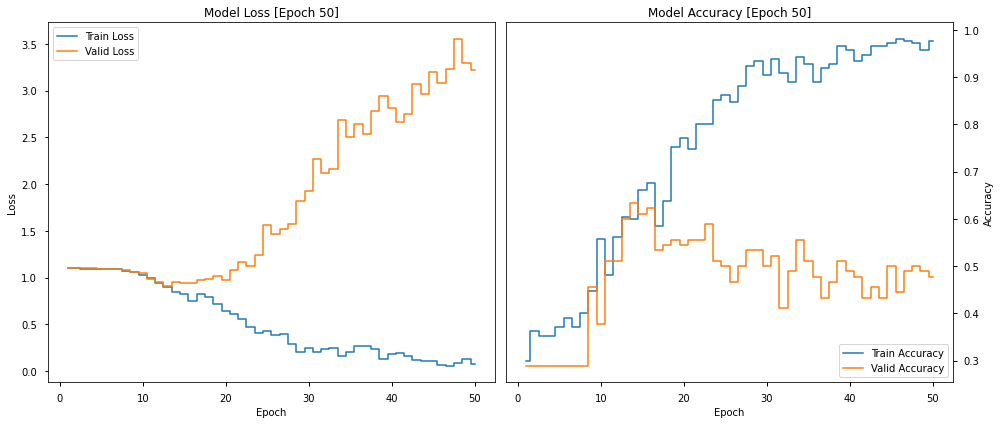

In [ ]:
#plot the train/valid loss and train/valid accuracy 
plot_train_curves(H.history)

In [ ]:
#applying all of the test data to the model. 
predictionsCNN = modelCNN.predict(CNNTestData)

#storing the highest predictions.
yPred = predictionsCNN.argmax(axis=1)

# Compare the truth with predictions and print a report
#yTrue = testGen.classes
report = classification_report(CNNTestLabels.argmax(axis=1),
                               yPred,
                               target_names=["HII","PNE","RG"])
print(report)

3/3 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

         HII       0.39      0.46      0.42        26
         PNE       0.51      0.55      0.53        33
          RG       0.54      0.42      0.47        31

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.49      0.48      0.48        90



Plotting the confusion matrix:

Normalized confusion matrix
[[12  8  6]
 [10 18  5]
 [ 9  9 13]]


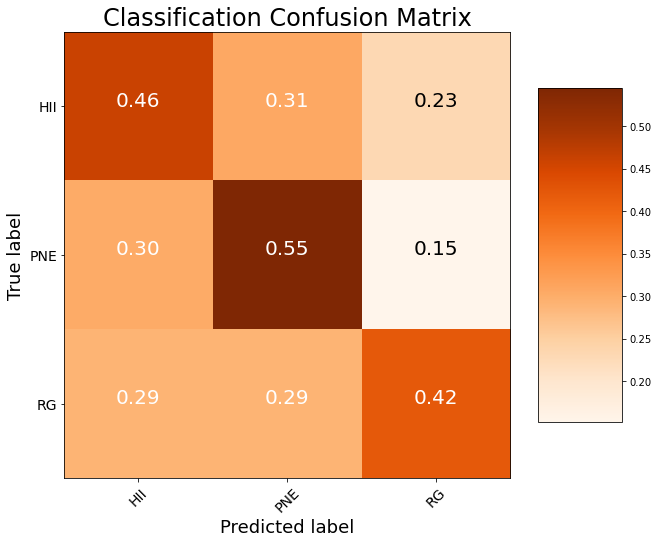

In [ ]:
cmatrix = confusion_matrix(CNNTestLabels.argmax(axis=1), yPred)
plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

With the default hyperparameters, CNN does a better job at correctly identifying all labels compared to ANN. 

## Evaluate the performance of the CNN



Once your model is trained, run a few predictions using the test data and compare with the known label. Then, produce a classification report using the test data. Using the saved history from your model fit, plot on separate graphs the evolution of the Training and Testing/Validation loss and the evolution of the Training and Testing/Validation accuracy. You can also use the plotting code from [lectorial in week 8](https://github.com/MQ-ASTR3110-2021/ASTR3110_Tutorial_Notebooks_2021/blob/master/Solution_Notebooks/ASTR3110_Tutorial_8_Random_Forest.ipynb) to produce a confusion matrix to help assess the classifier. Based on the outputs of the classification report and the plots, assess the performance of the classifier.
</font>

Making a modelling function

In [ ]:
def cnnFn(trainData, trainLabels, testData, testLabels, layers: int, neurons: float, numEpochs: int, learnRate: float, momentum: float):
  '''
  layers = number of layers to add

  neurons = integer from 0.5 to 2.0. Either halving or doubling the number of neurons. 

  numEpochs = number of epochs to train the model. 
  '''
  
  modelCNN = Sequential()
  size = trainData.shape[1]
  inputShape = (size, size, 3)

  chanDim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (size, size, 3)
    chanDim = 1
  

  modelCNN.add(Conv2D(32*neurons, (3,3), input_shape = inputShape))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Conv2D(32*neurons, (3,3)))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Conv2D(64*neurons, (3,3))) 
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 1:
    modelCNN.add(Conv2D(64*neurons, (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 2:
    modelCNN.add(Conv2D(64*neurons, (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Flatten()) 
  modelCNN.add(Dense(64))
  modelCNN.add(Activation('relu'))
  modelCNN.add(Dropout(0.5))

  nClasses = 3
  modelCNN.add(Dense(nClasses))
  modelCNN.add(Activation('softmax'))

  # Optimiser and compiler
  opt = SGD(learning_rate= learnRate, momentum= momentum)

  modelCNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  batchSize = 32

  # Running the CNN model
  H = modelCNN.fit(trainData, trainLabels, 
                validation_data=(testData, testLabels),
                batch_size= batchSize, epochs = numEpochs, verbose= 0)


  # Plot the train/valid loss and train/valid accuracy 
  plot_train_curves(H.history)

  # Modelling all the test data
  predictionsCNN = modelCNN.predict(testData)
  yPred = predictionsCNN.argmax(axis=1)

  # Printing classification report
  report = classification_report(testLabels.argmax(axis=1),
                                yPred,
                                target_names=["HII","PNE","RG"])
  print(report)

  cmatrix = confusion_matrix(testLabels.argmax(axis=1), yPred)
  plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                        title = 'Classification Confusion Matrix', normalize=True)
  print(cmatrix)

### Checking the performance when tweaking learn rate, momentum and number of epochs. 

numEpochs = 50

learnRate = 0.01

momentum = 1.0



3/3 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

         HII       0.75      0.46      0.57        26
         PNE       0.33      0.12      0.18        33
          RG       0.44      0.87      0.58        31

    accuracy                           0.48        90
   macro avg       0.51      0.48      0.44        90
weighted avg       0.49      0.48      0.43        90

Normalized confusion matrix
[[12  5  9]
 [ 3  4 26]
 [ 1  3 27]]


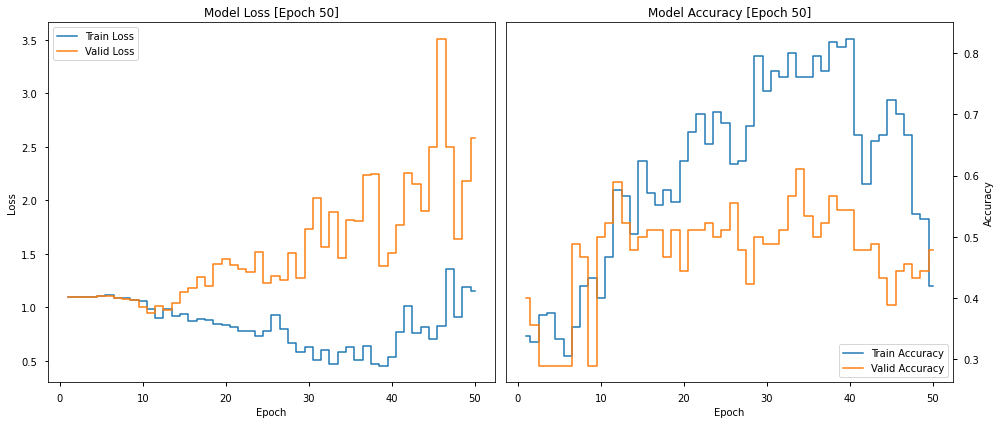

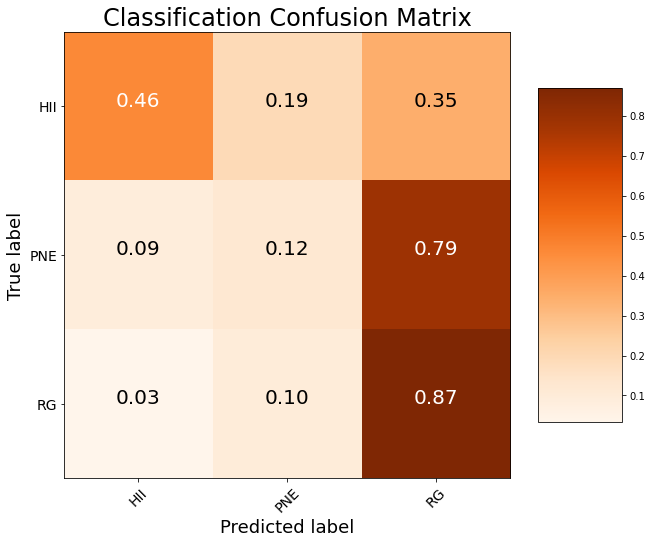

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 50, learnRate = 0.01, momentum = 1.0 )

Setting 30 epochs as the default number of epochs.

numEpochs = 30

learnRate = 0.005

momentum = 1.0

3/3 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

         HII       0.63      0.65      0.64        26
         PNE       0.37      0.39      0.38        33
          RG       0.39      0.35      0.37        31

    accuracy                           0.46        90
   macro avg       0.46      0.47      0.47        90
weighted avg       0.45      0.46      0.45        90

Normalized confusion matrix
[[17  7  2]
 [ 5 13 15]
 [ 5 15 11]]


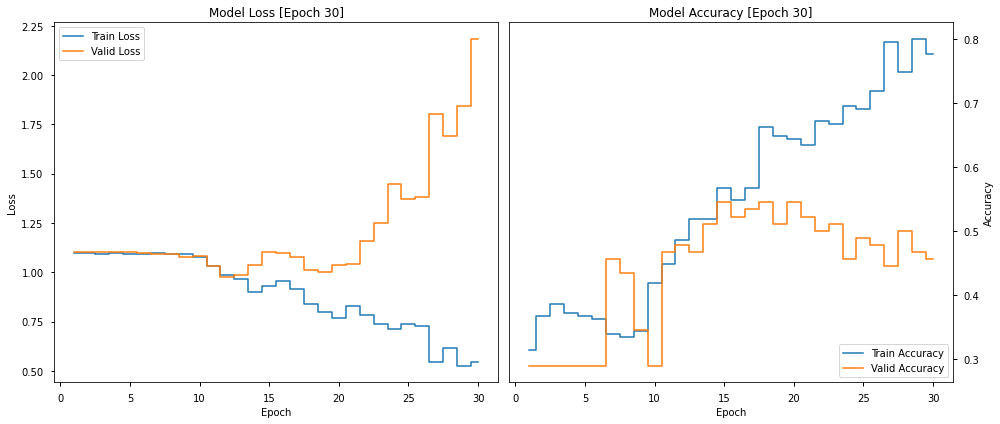

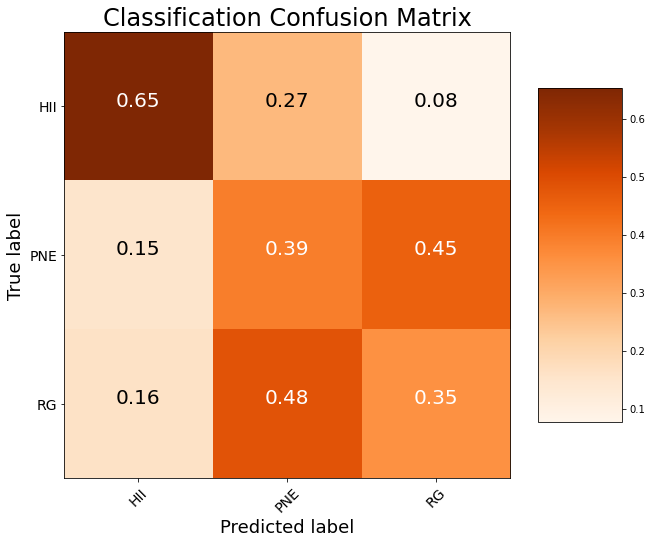

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 30, learnRate = 0.005, momentum = 1.0 )

numEpochs = 30

learnRate = 0.001

momentum = 1.0

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       0.55      0.69      0.61        26
         PNE       1.00      0.03      0.06        33
          RG       0.43      0.77      0.55        31

    accuracy                           0.48        90
   macro avg       0.66      0.50      0.41        90
weighted avg       0.67      0.48      0.39        90

Normalized confusion matrix
[[18  0  8]
 [ 8  1 24]
 [ 7  0 24]]


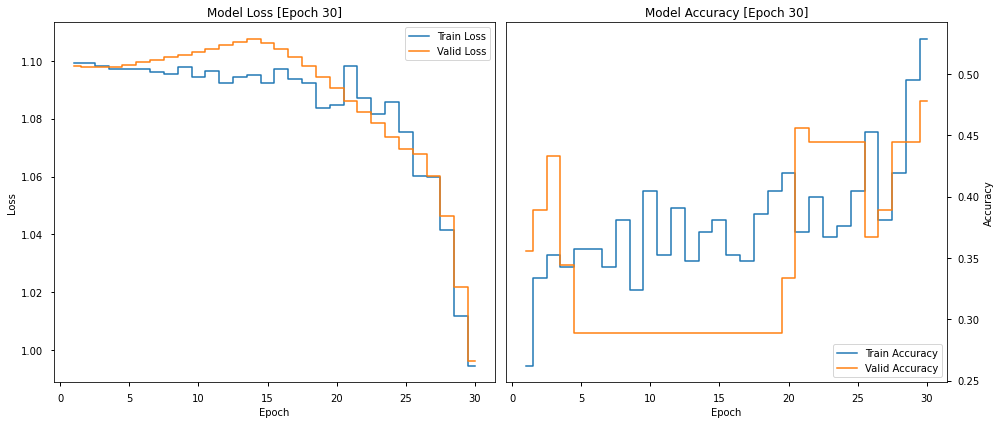

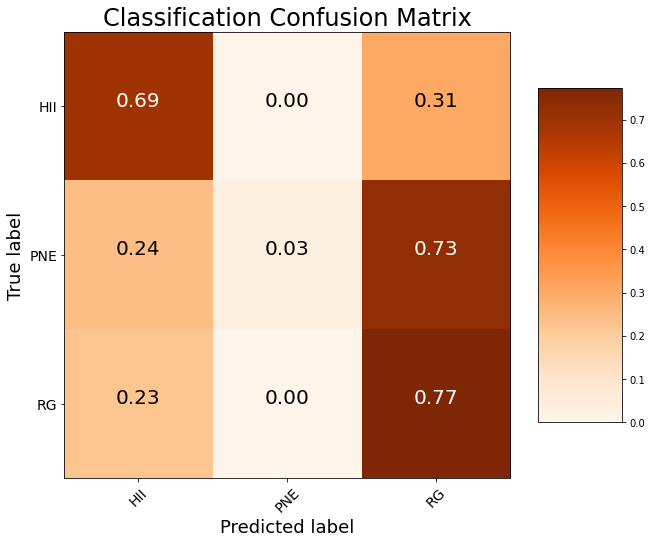

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 30, learnRate = 0.001, momentum = 1.0 )

numEpochs = 30

learnRate = 0.01

momentum = 0.9

3/3 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

         HII       0.79      0.73      0.76        26
         PNE       0.48      0.33      0.39        33
          RG       0.53      0.74      0.62        31

    accuracy                           0.59        90
   macro avg       0.60      0.60      0.59        90
weighted avg       0.59      0.59      0.58        90

Normalized confusion matrix
[[19  6  1]
 [ 3 11 19]
 [ 2  6 23]]


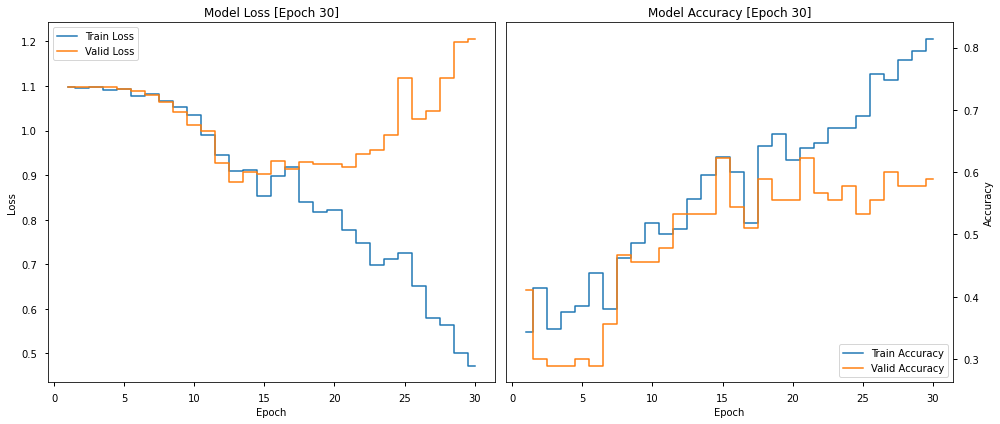

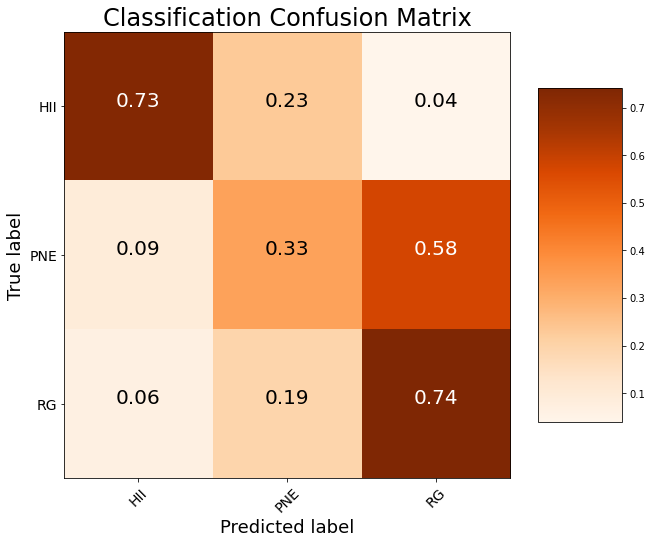

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 30, learnRate = 0.01, momentum = 0.9 )

numEpochs = 30

learnRate = 0.005

momentum = 0.9

3/3 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

         HII       0.76      0.62      0.68        26
         PNE       0.36      0.15      0.21        33
          RG       0.51      0.90      0.65        31

    accuracy                           0.54        90
   macro avg       0.54      0.56      0.51        90
weighted avg       0.53      0.54      0.50        90

Normalized confusion matrix
[[16  7  3]
 [ 4  5 24]
 [ 1  2 28]]


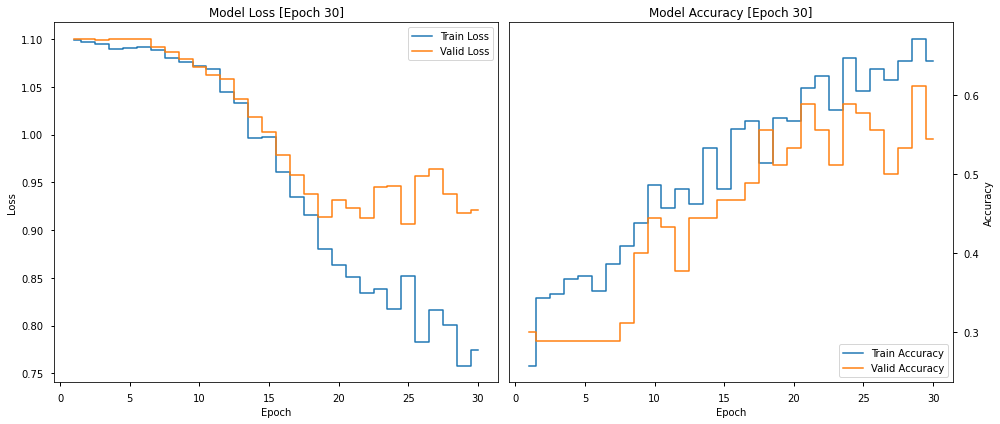

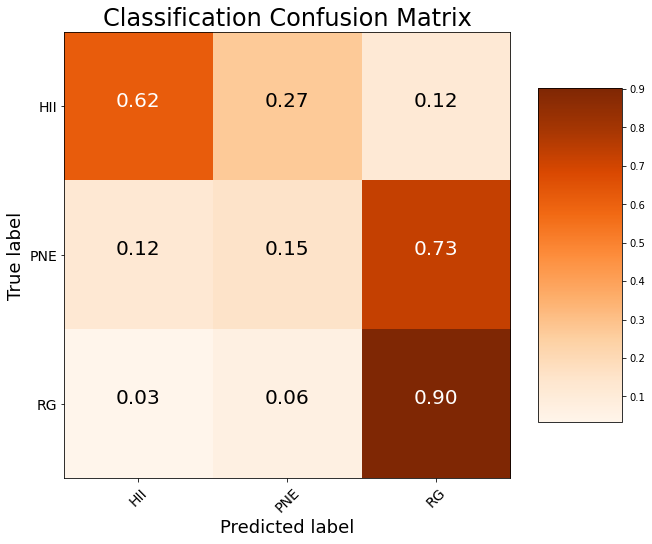

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 30, learnRate = 0.005, momentum = 0.9 )

numEpochs = 30

learnRate = 0.001

momentum = 0.9

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       0.29      1.00      0.45        26
         PNE       0.00      0.00      0.00        33
          RG       0.00      0.00      0.00        31

    accuracy                           0.29        90
   macro avg       0.10      0.33      0.15        90
weighted avg       0.08      0.29      0.13        90

Normalized confusion matrix
[[26  0  0]
 [33  0  0]
 [31  0  0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


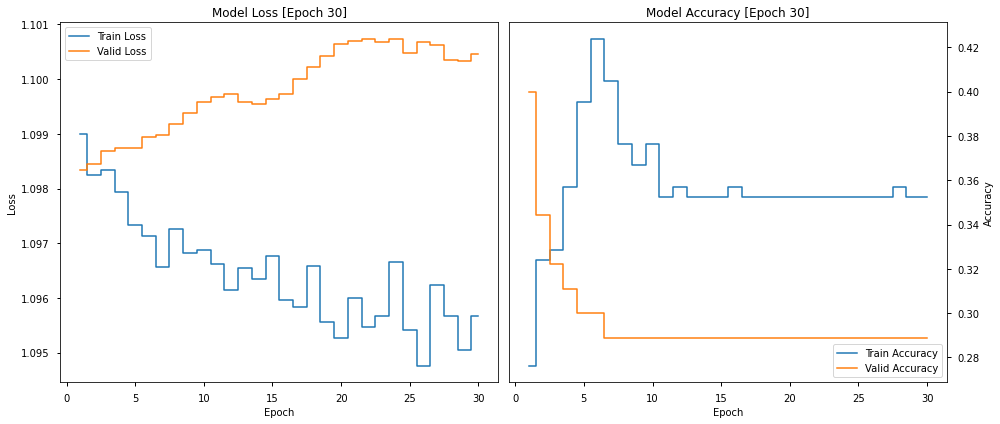

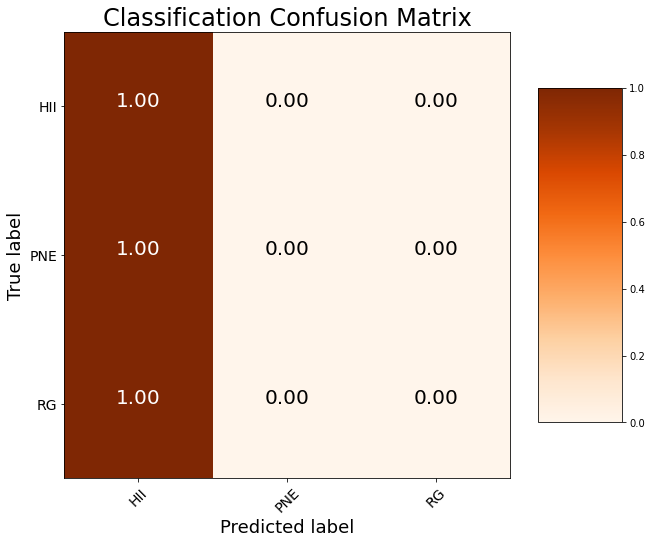

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 30, learnRate = 0.001, momentum = 0.9)

Remarks: 

need to up the epochs for 0.005 learning rate with 1.0 momentum

3/3 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

         HII       0.71      0.77      0.74        26
         PNE       0.48      0.33      0.39        33
          RG       0.51      0.65      0.57        31

    accuracy                           0.57        90
   macro avg       0.57      0.58      0.57        90
weighted avg       0.56      0.57      0.55        90

Normalized confusion matrix
[[20  4  2]
 [ 5 11 17]
 [ 3  8 20]]


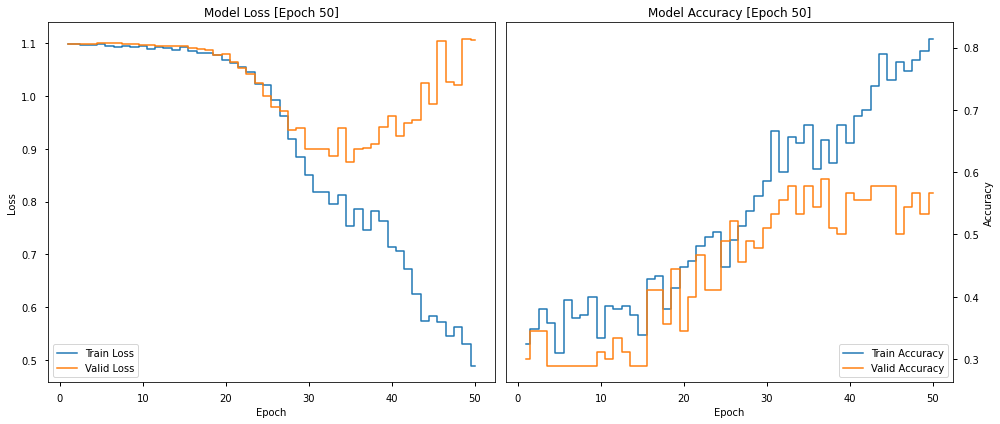

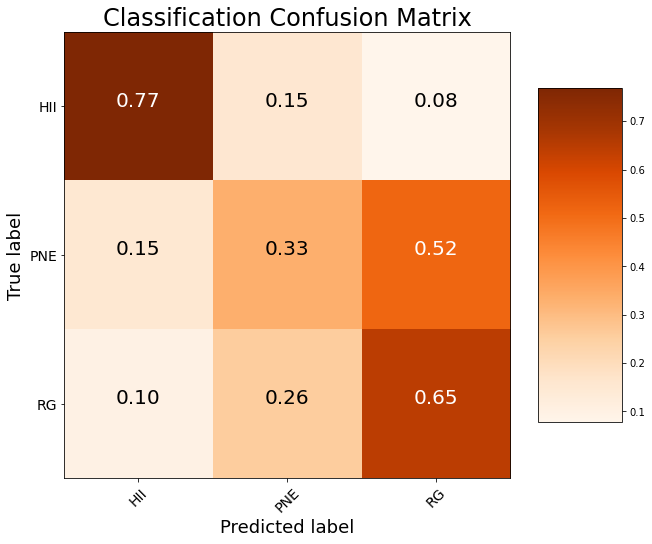

In [ ]:
cnnFn(CNNTrainData, CNNTrainLabels, CNNTestData, CNNTestLabels, layers = 1, neurons= 1.0, numEpochs = 50, learnRate = 0.005, momentum = 0.9)

Overfitting occurs after aroud 30 epochs. Overfitting is when the validation loss function begins to increase and the validation accuracy function plateaus. The amount of validation lost is around 0.8 and accuracy is around 55%.

## Tweak the CNN to improve performance


As before, try to improve your classifier by changing the following:

- The learning rate and number of epochs (smaller learning rate generally requires more training epochs and vice versa).
- The number of hidden layers (only try 1-2 extra).
- The number of neurons in the layers (again, only try 1-2 different values).
- You may also try changing the input resolution of the images.

For each tweak, run the classification reports, generate a confusion matrix, and produce plots of the history of the Loss and Accuracy and give a brief assessment of the performance. 

Finally, give a summary report for the best classifier achieved, and outline which of the changes was most effective. How did your best CNN classifier compare with your best ANN classifier?</font>

----------

Modifying the cnn function again to include descending number of neurons.

We could also include the line of code that splits the train and test data so that each time the function is called, a new arrangement of the train and test data is split. This will show that everytime the model is run on the same hyperparameters, a new split dataset is made and will provide different results. 

In [ ]:
def cnnFn(trainData, trainLabels, testData, testLabels, layers: int, neurons: float, neuronsDescending: bool(), numEpochs: int, learnRate: float, momentum: float):
  '''
  layers = number of layers to add

  neurons = integer from 0.5 to 2.0. Either halving or doubling the number of neurons. 

  numEpochs = number of epochs to train the model. 
  '''
  
  modelCNN = Sequential()
  size = trainData.shape[1]
  inputShape = (size, size, 3)

  chanDim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (size, size, 3)
    chanDim = 1
  
  neurons = [neurons, neurons]

  modelCNN.add(Conv2D(32*neurons[0], (3,3), input_shape = inputShape))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Conv2D(32*neurons[0], (3,3)))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if neuronsDescending == True:
    neurons = [neurons[0]*0.5, neurons[1]*0.25]

  modelCNN.add(Conv2D(64*neurons[0], (3,3))) 
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 1:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 2:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Flatten()) 
  modelCNN.add(Dense(64))
  modelCNN.add(Activation('relu'))
  modelCNN.add(Dropout(0.5))

  nClasses = 3
  modelCNN.add(Dense(nClasses))
  modelCNN.add(Activation('softmax'))

  # Optimiser and compiler
  opt = SGD(learning_rate= learnRate, momentum= momentum)

  modelCNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  batchSize = 32

  # Running the CNN model
  H = modelCNN.fit(trainData, trainLabels, 
                validation_data=(testData, testLabels),
                batch_size= batchSize, epochs = numEpochs, verbose= 0)


  # Plot the train/valid loss and train/valid accuracy 
  plot_train_curves(H.history)

  # Modelling all the test data
  predictionsCNN = modelCNN.predict(testData)
  yPred = predictionsCNN.argmax(axis=1)

  # Printing classification report
  report = classification_report(testLabels.argmax(axis=1),
                                yPred,
                                target_names=["HII","PNE","RG"])
  print(report)

  cmatrix = confusion_matrix(testLabels.argmax(axis=1), yPred)
  plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                        title = 'Classification Confusion Matrix', normalize=True)
  print(cmatrix)

Modelling with the best hyperparameters found previously

3/3 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

         HII       0.77      0.88      0.82        26
         PNE       0.75      0.27      0.40        33
          RG       0.58      0.90      0.71        31

    accuracy                           0.67        90
   macro avg       0.70      0.69      0.64        90
weighted avg       0.70      0.67      0.63        90

Normalized confusion matrix
[[23  1  2]
 [ 6  9 18]
 [ 1  2 28]]


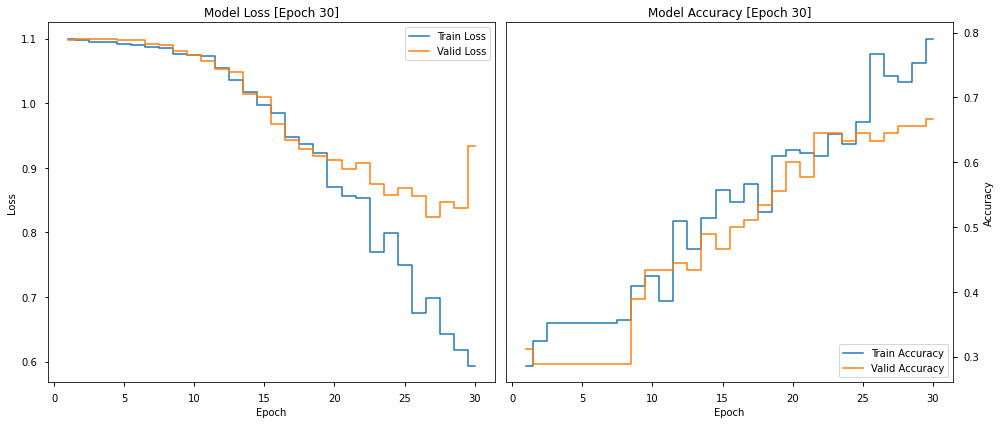

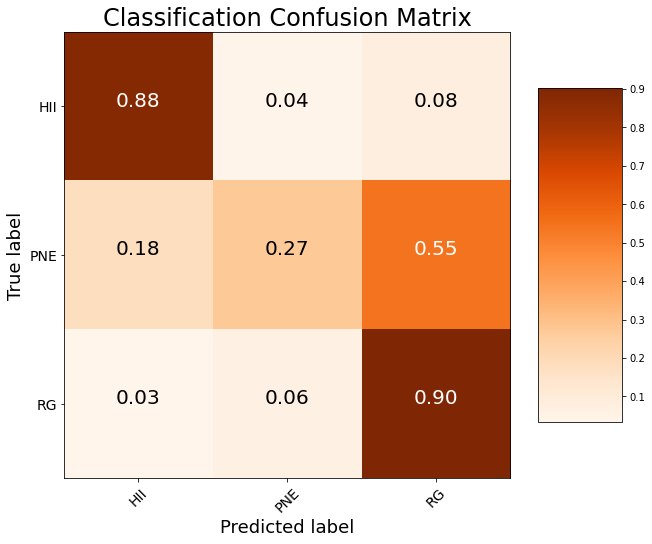

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 0, 
      neurons= 1.0, 
      neuronsDescending = False, 
      numEpochs = 30, 
      learnRate = 0.005, 
      momentum = 0.9)

Descending number of neurons in each following layer with the same hyperparameters.

3/3 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

         HII       0.76      0.73      0.75        26
         PNE       0.54      0.42      0.47        33
          RG       0.62      0.77      0.69        31

    accuracy                           0.63        90
   macro avg       0.64      0.64      0.64        90
weighted avg       0.63      0.63      0.63        90

Normalized confusion matrix
[[19  6  1]
 [ 5 14 14]
 [ 1  6 24]]


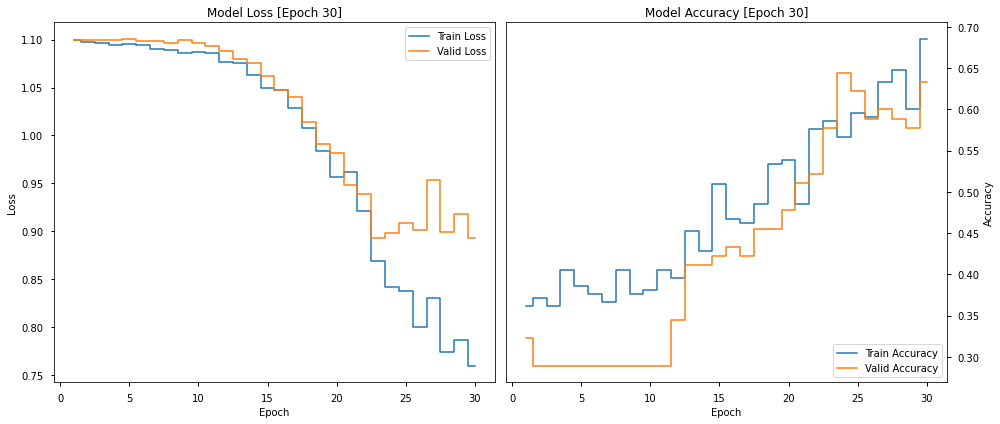

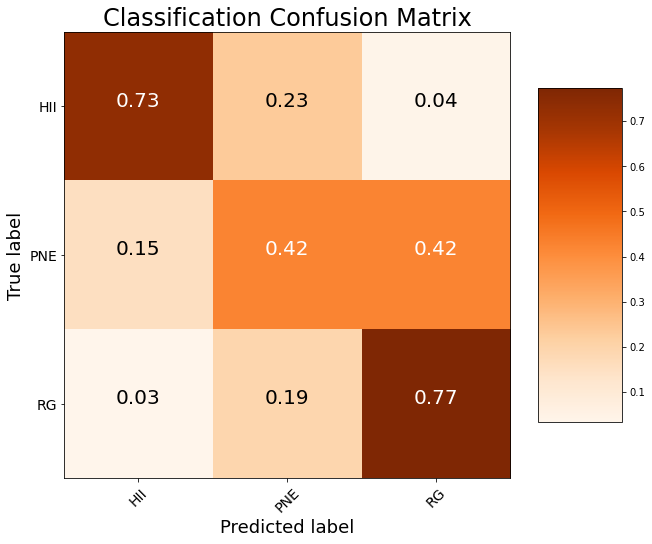

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 0, 
      neurons= 1.0, 
      neuronsDescending = True, 
      numEpochs = 30, 
      learnRate = 0.005, 
      momentum = 0.9)

Adding a layer, default number of neurons

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       0.76      0.62      0.68        26
         PNE       0.40      0.06      0.11        33
          RG       0.47      0.97      0.63        31

    accuracy                           0.53        90
   macro avg       0.54      0.55      0.47        90
weighted avg       0.53      0.53      0.45        90

Normalized confusion matrix
[[16  3  7]
 [ 4  2 27]
 [ 1  0 30]]


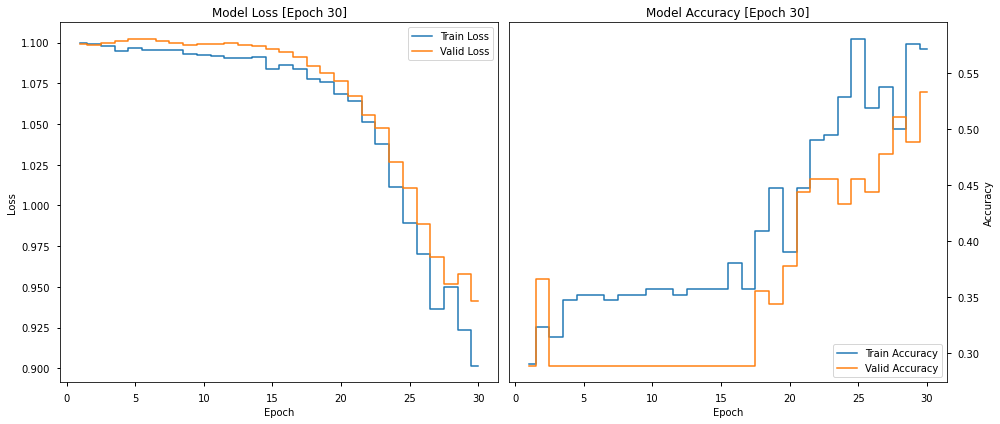

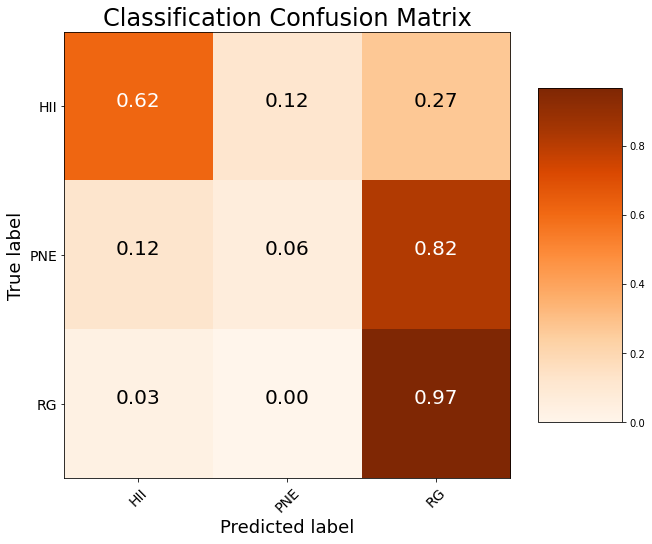

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 1.0, 
      neuronsDescending = False, 
      numEpochs = 30, 
      learnRate = 0.005, 
      momentum = 0.9)

Performs better.

Added layer with descending number of layers. 

3/3 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         HII       0.77      0.77      0.77        26
         PNE       0.44      0.21      0.29        33
          RG       0.52      0.81      0.63        31

    accuracy                           0.58        90
   macro avg       0.58      0.60      0.56        90
weighted avg       0.56      0.58      0.54        90

Normalized confusion matrix
[[20  4  2]
 [ 5  7 21]
 [ 1  5 25]]


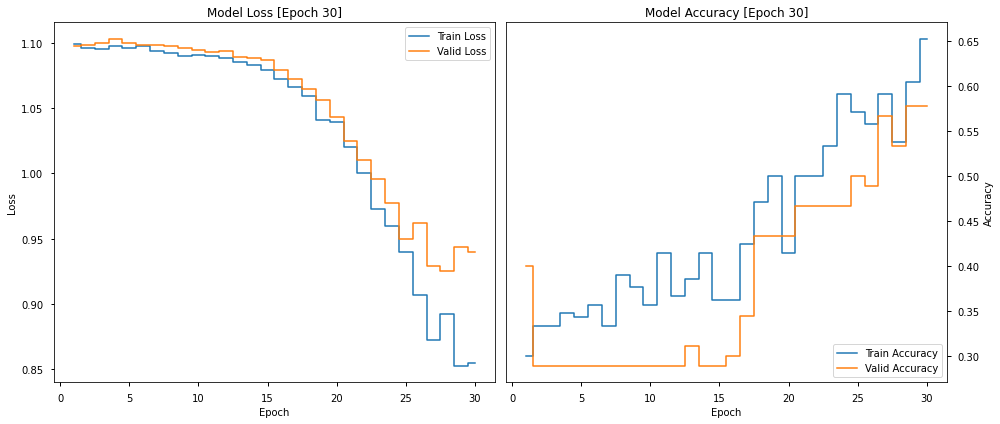

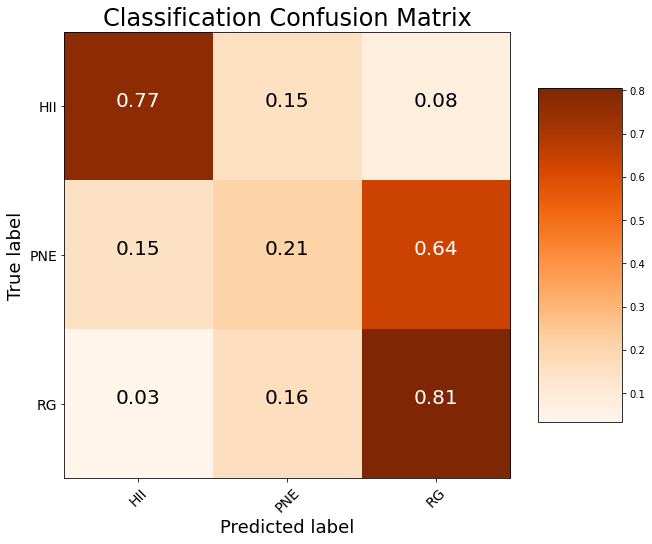

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 1.0, 
      neuronsDescending = True, 
      numEpochs = 30, 
      learnRate = 0.005, 
      momentum = 0.9)

Poor performance. 

Added two extra layers and descending number of neurons.

3/3 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

         HII       0.67      0.46      0.55        26
         PNE       0.00      0.00      0.00        33
          RG       0.41      0.94      0.57        31

    accuracy                           0.46        90
   macro avg       0.36      0.47      0.37        90
weighted avg       0.33      0.46      0.35        90

Normalized confusion matrix
[[12  1 13]
 [ 4  0 29]
 [ 2  0 29]]


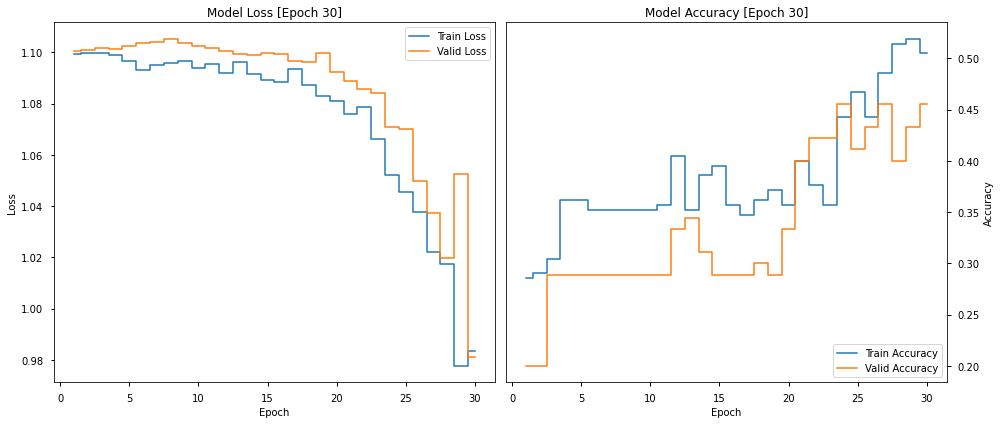

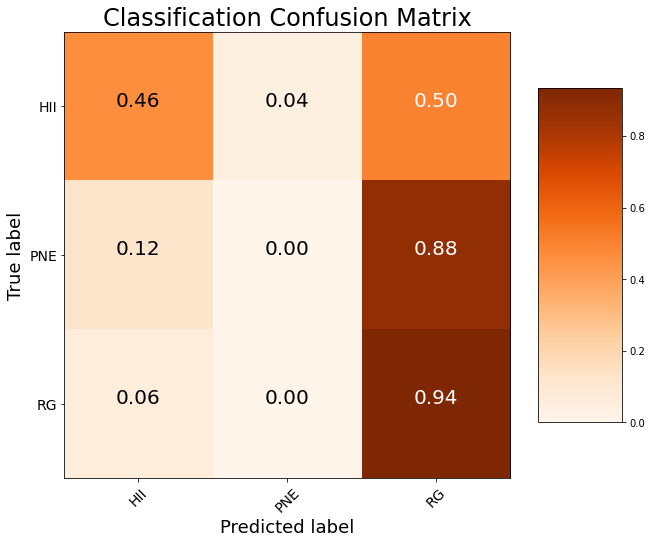

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 2, 
      neurons= 1.0, 
      neuronsDescending = True, 
      numEpochs = 30, 
      learnRate = 0.005, 
      momentum = 0.9)

Poor performance. 

1 extra layer, double the neurons, 50 epochs

3/3 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

         HII       0.82      0.69      0.75        26
         PNE       0.48      0.45      0.47        33
          RG       0.57      0.68      0.62        31

    accuracy                           0.60        90
   macro avg       0.62      0.61      0.61        90
weighted avg       0.61      0.60      0.60        90

Normalized confusion matrix
[[18  7  1]
 [ 3 15 15]
 [ 1  9 21]]


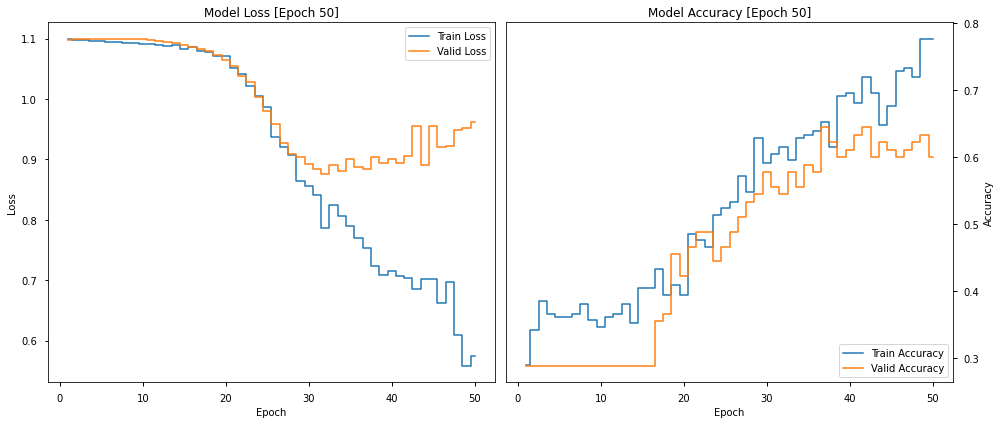

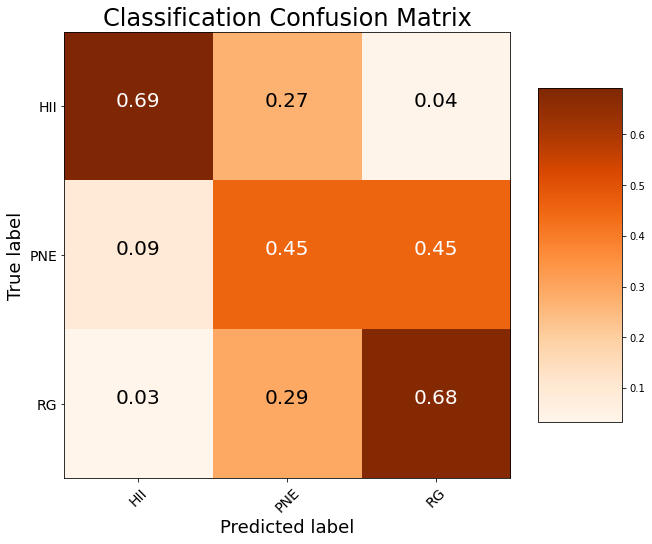

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 2.0, 
      neuronsDescending = False, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Overfitting occurs around epoch 30. 

1 extra layer, double neurons, descending number of neurons.

3/3 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

         HII       0.65      0.85      0.73        26
         PNE       0.44      0.36      0.40        33
          RG       0.59      0.55      0.57        31

    accuracy                           0.57        90
   macro avg       0.56      0.59      0.57        90
weighted avg       0.55      0.57      0.55        90

Normalized confusion matrix
[[22  4  0]
 [ 9 12 12]
 [ 3 11 17]]


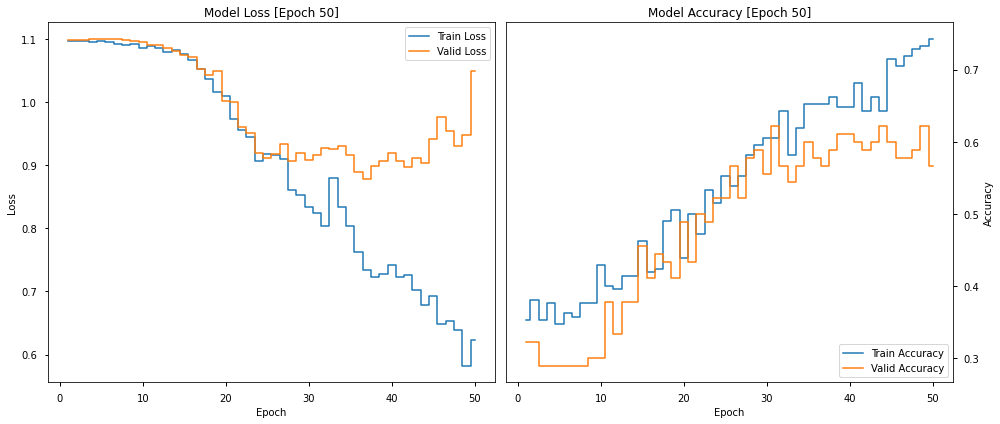

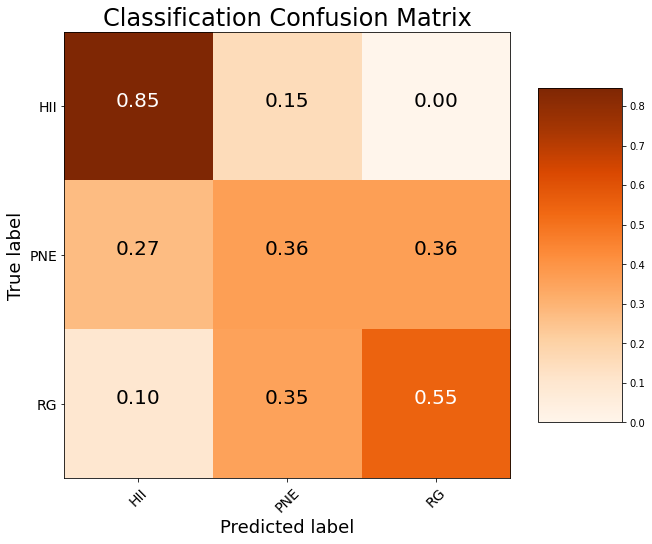

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 2.0, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Best so far, overfitting occurs around epoch 45. 

2 Extra layers, double neurons.

3/3 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

         HII       0.82      0.69      0.75        26
         PNE       0.47      0.42      0.44        33
          RG       0.55      0.68      0.61        31

    accuracy                           0.59        90
   macro avg       0.61      0.60      0.60        90
weighted avg       0.60      0.59      0.59        90

Normalized confusion matrix
[[18  7  1]
 [ 3 14 16]
 [ 1  9 21]]


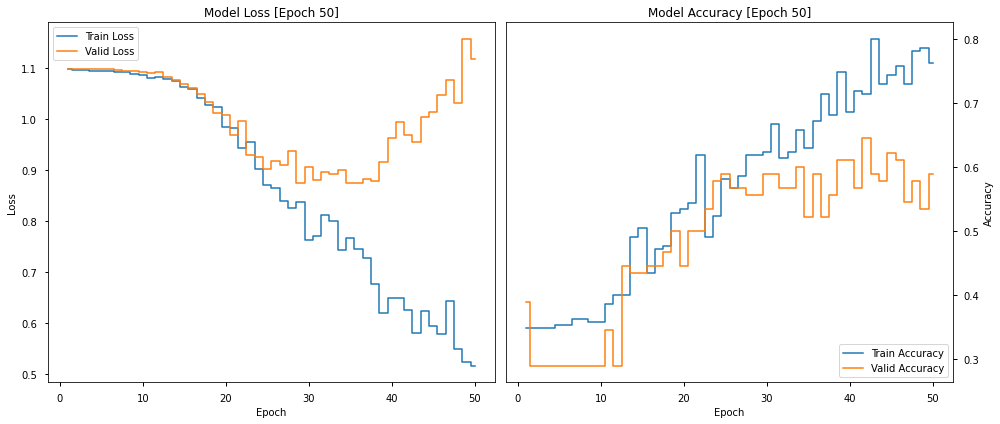

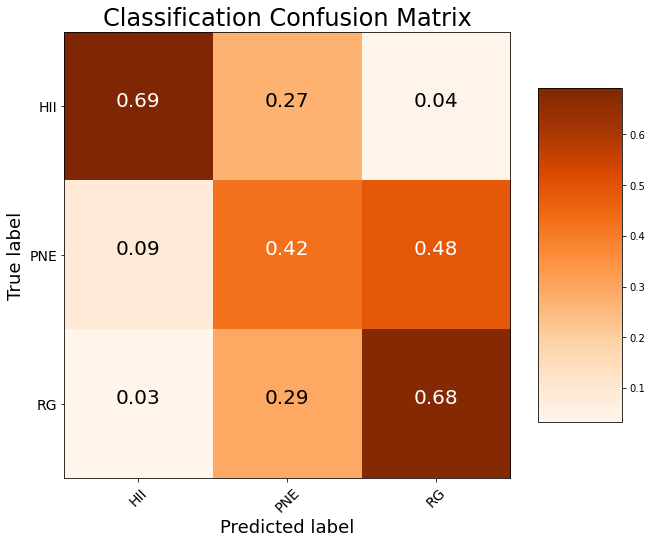

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 2, 
      neurons= 2.0, 
      neuronsDescending = False, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Overfitting around epoch 30, but loss function is still high and accuracy function is low at that epoch. 

2 extra layers, double neurons, descending number of neurons

3/3 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

         HII       0.81      0.81      0.81        26
         PNE       0.52      0.48      0.50        33
          RG       0.61      0.65      0.62        31

    accuracy                           0.63        90
   macro avg       0.64      0.65      0.64        90
weighted avg       0.63      0.63      0.63        90

Normalized confusion matrix
[[21  5  0]
 [ 4 16 13]
 [ 1 10 20]]


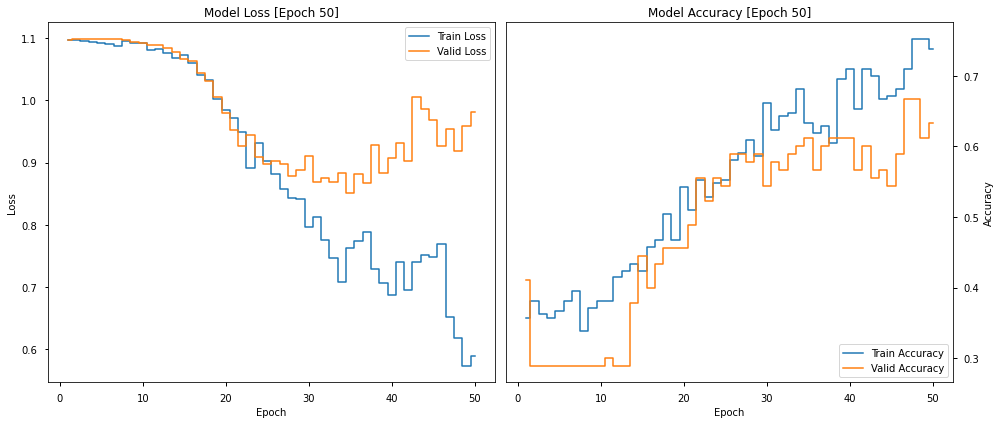

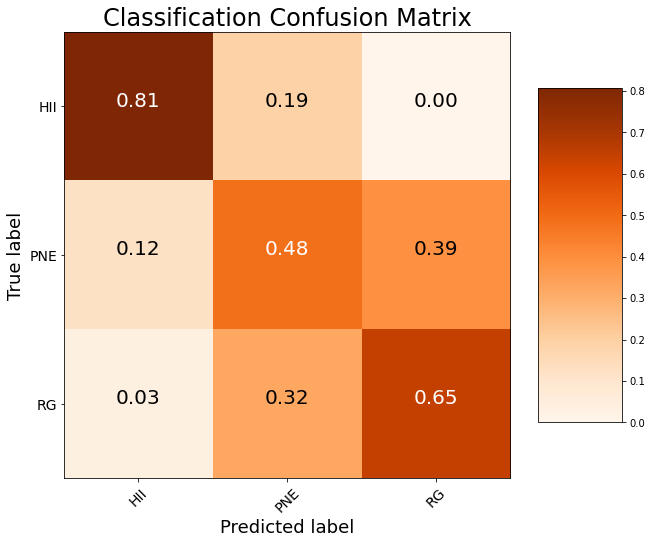

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 2, 
      neurons= 2.0, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Similar to the previous model but slightly better performance. 

---

Halving the neurons. First 0 extra layers, then 1 then 2. 

3/3 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

         HII       0.65      0.65      0.65        26
         PNE       0.55      0.52      0.53        33
          RG       0.61      0.65      0.62        31

    accuracy                           0.60        90
   macro avg       0.60      0.60      0.60        90
weighted avg       0.60      0.60      0.60        90

Normalized confusion matrix
[[17  7  2]
 [ 5 17 11]
 [ 4  7 20]]


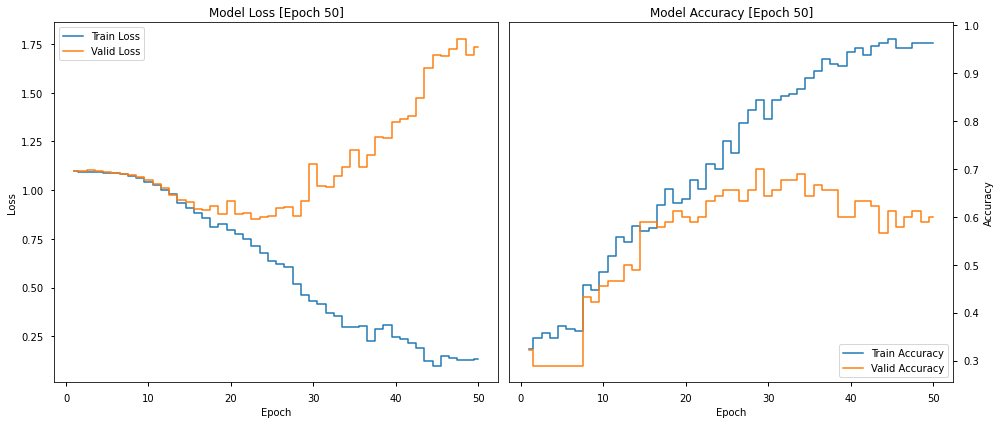

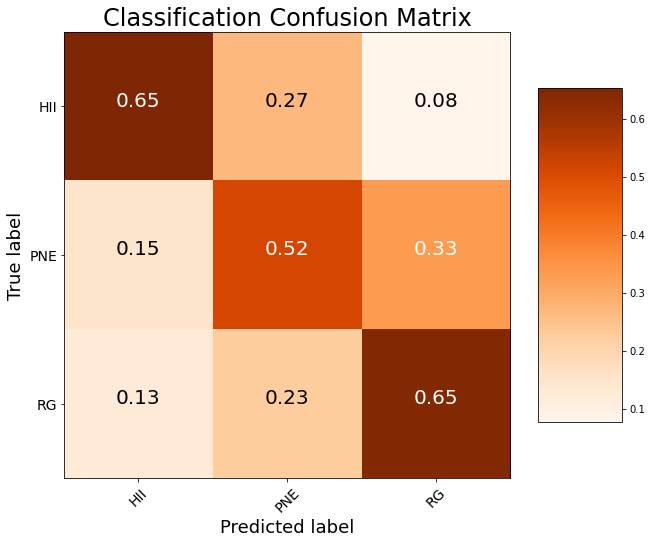

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 0, 
      neurons= 0.5, 
      neuronsDescending = False, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Seen similar performance previously but still poor. 

No extra layers, half the number of neurons with descending number of neurons. 

3/3 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

         HII       0.65      0.77      0.70        26
         PNE       0.58      0.33      0.42        33
          RG       0.57      0.74      0.65        31

    accuracy                           0.60        90
   macro avg       0.60      0.61      0.59        90
weighted avg       0.60      0.60      0.58        90

Normalized confusion matrix
[[20  3  3]
 [ 8 11 14]
 [ 3  5 23]]


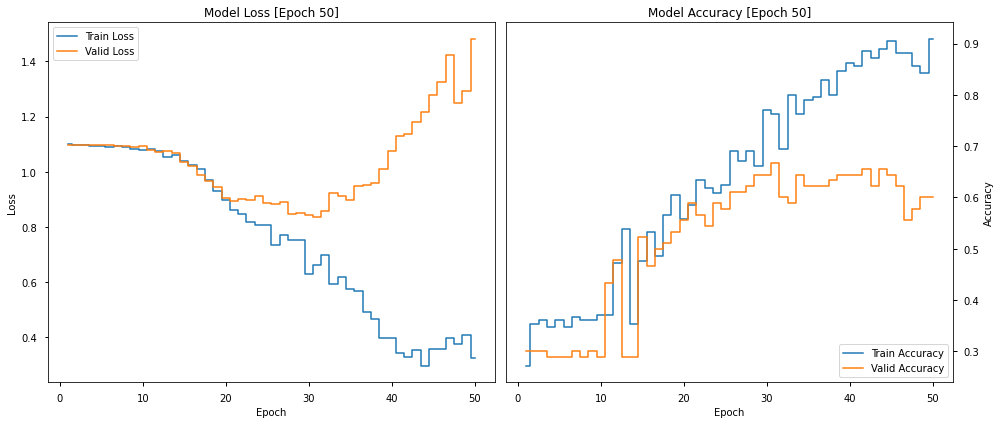

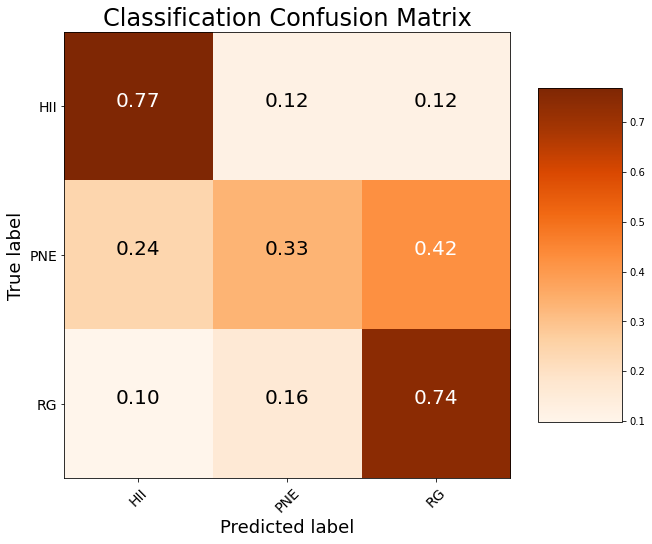

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 0, 
      neurons= 0.5, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

Again, poor performance. 

----

1 layer

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         HII       0.62      0.88      0.73        26
         PNE       0.50      0.18      0.27        33
          RG       0.59      0.77      0.67        31

    accuracy                           0.59        90
   macro avg       0.57      0.61      0.55        90
weighted avg       0.56      0.59      0.54        90

Normalized confusion matrix
[[23  2  1]
 [11  6 16]
 [ 3  4 24]]


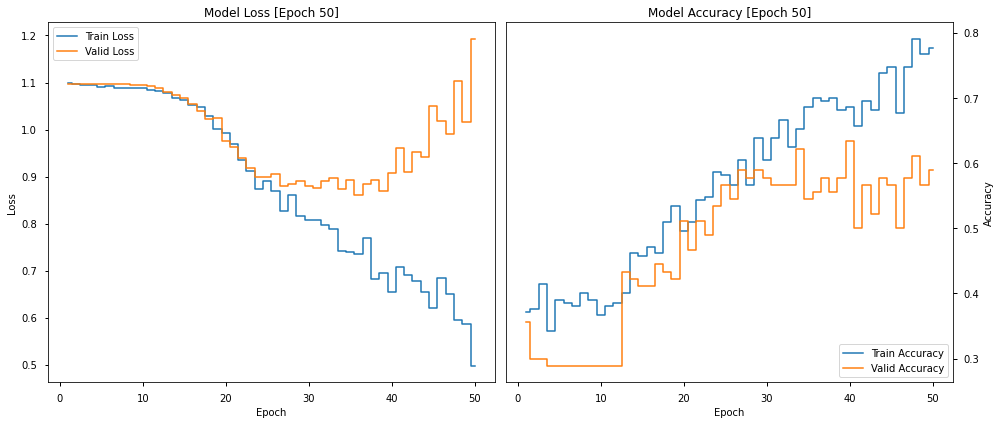

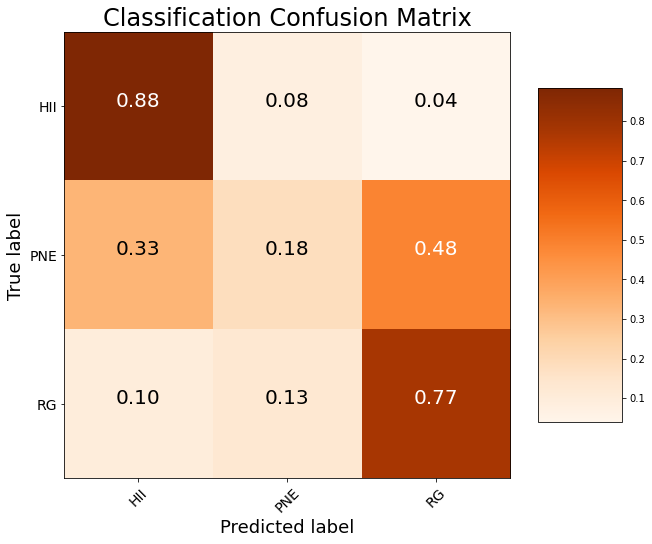

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 0.5, 
      neuronsDescending = False, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         HII       0.78      0.69      0.73        26
         PNE       0.50      0.12      0.20        33
          RG       0.49      0.94      0.64        31

    accuracy                           0.57        90
   macro avg       0.59      0.58      0.52        90
weighted avg       0.58      0.57      0.51        90

Normalized confusion matrix
[[18  3  5]
 [ 4  4 25]
 [ 1  1 29]]


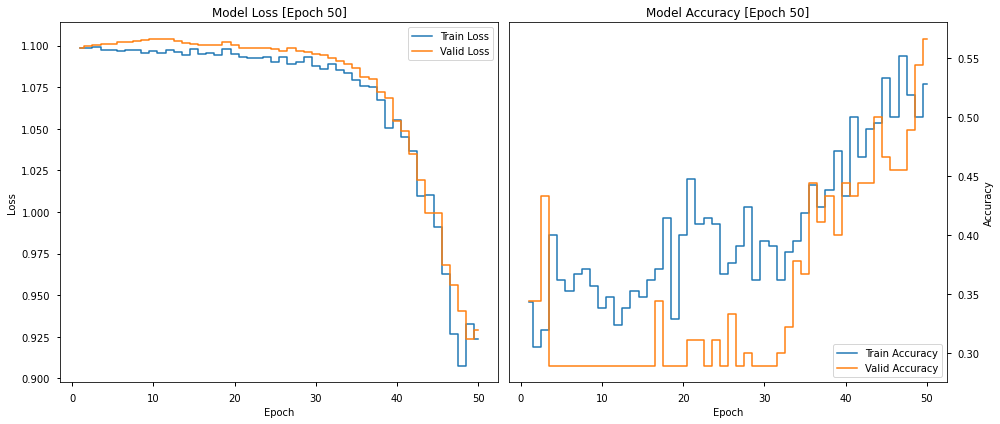

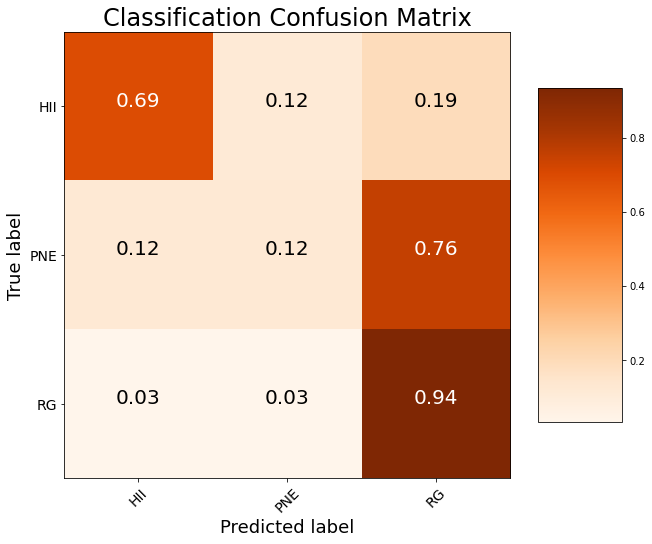

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 1, 
      neurons= 0.5, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

2 layers

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         HII       0.76      0.73      0.75        26
         PNE       0.50      0.27      0.35        33
          RG       0.57      0.87      0.69        31

    accuracy                           0.61        90
   macro avg       0.61      0.62      0.60        90
weighted avg       0.60      0.61      0.58        90

Normalized confusion matrix
[[19  6  1]
 [ 5  9 19]
 [ 1  3 27]]


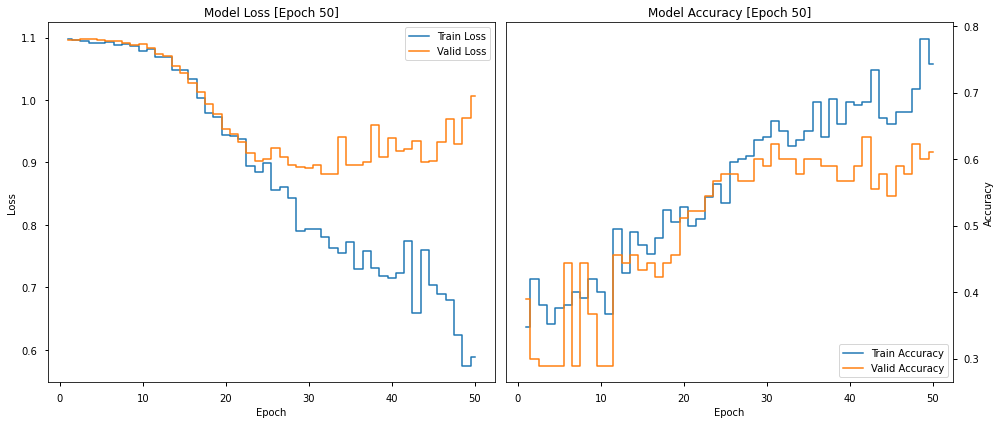

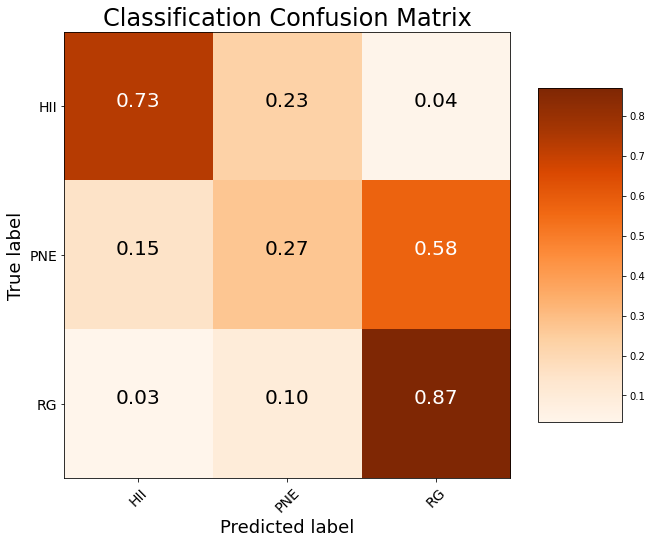

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 2, 
      neurons= 0.5, 
      neuronsDescending = False, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

3/3 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

         HII       0.80      0.77      0.78        26
         PNE       0.55      0.36      0.44        33
          RG       0.58      0.81      0.68        31

    accuracy                           0.63        90
   macro avg       0.64      0.65      0.63        90
weighted avg       0.63      0.63      0.62        90

Normalized confusion matrix
[[20  5  1]
 [ 4 12 17]
 [ 1  5 25]]


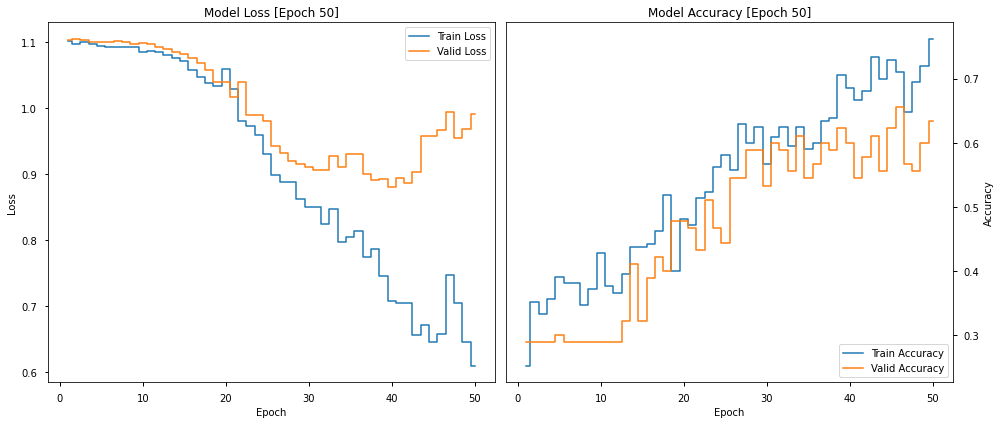

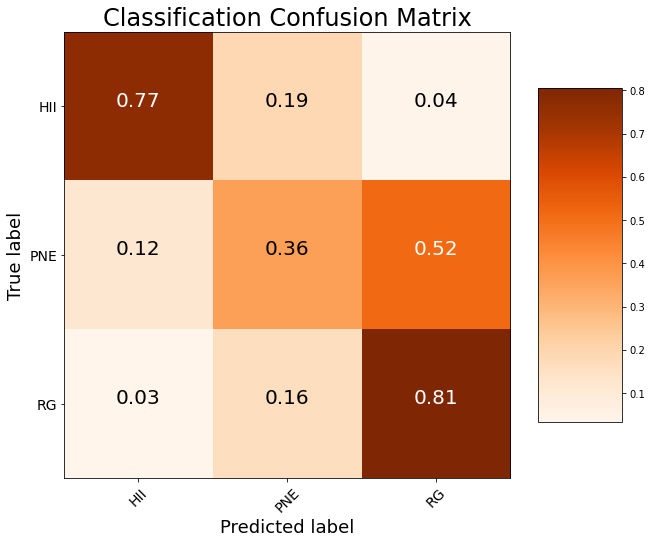

In [ ]:
cnnFn(CNNTrainData, 
      CNNTrainLabels, 
      CNNTestData, 
      CNNTestLabels, 
      layers = 2, 
      neurons= 0.5, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

The following hyperparameters provided the best result of no overfitting: 

- 1 added layer
- half the neurons
- descending number of neurons
- 0.005 learning rate
- 0.9 momentum.

Performance deteriorates when running a new model on the same split dataset. Redefining the function to include splitting the dataset.

In [ ]:
def cnnFn(layers: int, neurons: float, neuronsDescending: bool(), numEpochs: int, learnRate: float, momentum: float):
  '''
  layers = number of layers to add

  neurons = integer from 0.5 to 2.0. Either halving or doubling the number of neurons. 

  numEpochs = number of epochs to train the model. 
  '''
  
  trainData, testData, trainLabels, testLabels = train_test_split(combinedImages, combinedLabels, test_size=0.3) #combinedImages and combinedLabels  has been defined outside the function

  modelCNN = Sequential()
  size = trainData.shape[1]
  inputShape = (size, size, 3)

  chanDim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (size, size, 3)
    chanDim = 1
  
  neurons = [neurons, neurons]

  modelCNN.add(Conv2D(32*neurons[0], (3,3), input_shape = inputShape))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Conv2D(32*neurons[0], (3,3)))
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if neuronsDescending == True:
    neurons = [neurons[0]*0.5, neurons[1]*0.25]

  modelCNN.add(Conv2D(64*neurons[0], (3,3))) 
  modelCNN.add(Activation('relu'))
  modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 1:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  if layers == 2:
    modelCNN.add(Conv2D(64*neurons[1], (3,3))) 
    modelCNN.add(Activation('relu'))
    modelCNN.add(MaxPooling2D(pool_size=(2,2)))

  modelCNN.add(Flatten()) 
  modelCNN.add(Dense(64))
  modelCNN.add(Activation('relu'))
  modelCNN.add(Dropout(0.5))

  nClasses = 3
  modelCNN.add(Dense(nClasses))
  modelCNN.add(Activation('softmax'))

  # Optimiser and compiler
  opt = SGD(learning_rate= learnRate, momentum= momentum)

  modelCNN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  batchSize = 32

  # Running the CNN model
  H = modelCNN.fit(trainData, trainLabels, 
                validation_data=(testData, testLabels),
                batch_size= batchSize, epochs = numEpochs, verbose= 0)


  # Plot the train/valid loss and train/valid accuracy 
  plot_train_curves(H.history)

  # Modelling all the test data
  predictionsCNN = modelCNN.predict(testData)
  yPred = predictionsCNN.argmax(axis=1)

  # Printing classification report
  report = classification_report(testLabels.argmax(axis=1),
                                yPred,
                                target_names=["HII","PNE","RG"])
  print(report)

  cmatrix = confusion_matrix(testLabels.argmax(axis=1), yPred)
  plot_confusion_matrix(cmatrix, classes = ['HII', 'PNE', 'RG'],
                        title = 'Classification Confusion Matrix', normalize=True)
  print(cmatrix)

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         HII       0.83      0.66      0.73        29
         PNE       0.62      0.29      0.39        35
          RG       0.51      1.00      0.68        26

    accuracy                           0.61        90
   macro avg       0.65      0.65      0.60        90
weighted avg       0.66      0.61      0.58        90

Normalized confusion matrix
[[19  6  4]
 [ 4 10 21]
 [ 0  0 26]]


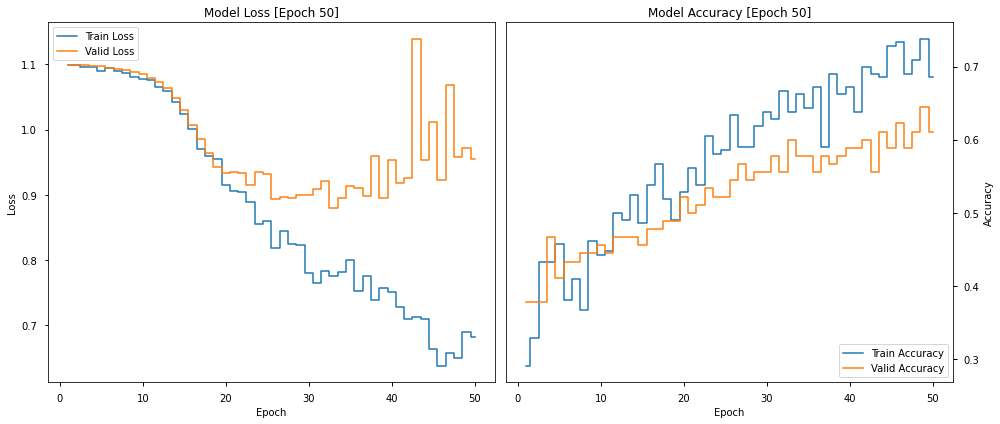

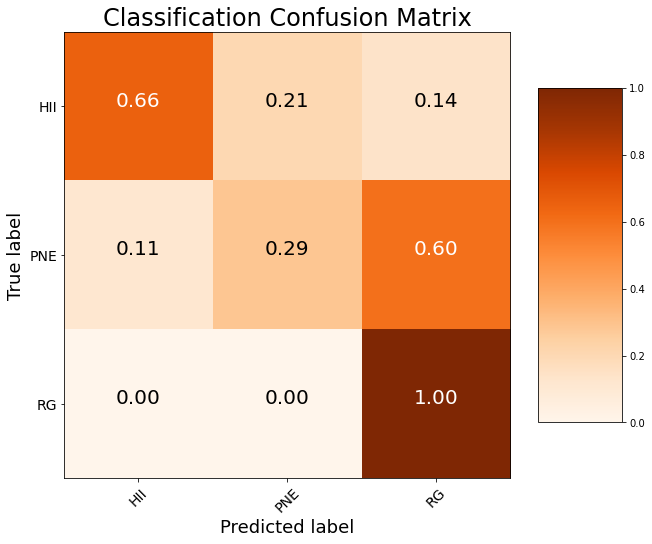

In [ ]:
cnnFn(layers = 1, 
      neurons= 0.5, 
      neuronsDescending = True, 
      numEpochs = 50, 
      learnRate = 0.005, 
      momentum = 0.9)

## Final remarks

Still lots to attempt with the CNN model i.e. changing the learn rate, momentum and epochs with added layers, double half number of neurons and whether each extra layer has a decreasing number of neurons. Might be worthwhile using Gaussian Mixture Modelling (GMM) seen in a previous lab to optimise the hyperparameters. 

When running the last model multiple times, we saw a variety of results. Bias is introduced when choosing the model that provides the 'best' results. We often saw the loss function decrease to about 0.7 and the accuracy function around the 0.65 mark however this fluctuated drastically. We might see improvements with the data augmentation section which involves changing the arrangements of the images. 

As we saw with the ANN model, correctly predicting PNE was the most difficult object for the CNN model, again, attributed to the complex shape PNE objects are characterised by. 

# Stretch Goal: Data Augmentation 


It is possible to increase the size of our training set by manipulating the current data. For example, we can increase the size of our training set by rotating each image by 90, 180, and 270 degrees. Because our images of HII regions, PNE and RGs can have very similar shapes, but many different orientations on the sky, adding rotated images can help the CNN better learn our data. Aside from rotation, there are many other ways to augment the data, e.g., mirror-imaging, scaling the size, changing the perspective, and more.

Here, you can modify your training dataset using the [ndimage.rotate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html) function. In principle, you can add as many random orientations as you like, but I suggest that you start by rotating the three images for each source by 90, 180, and 270 degrees. You will need to also produce a new set of labels for your expanded dataset. Rerun your best CNN classifier on this new training set. Can you seen an improvement in performance?
</font>

----
Example from documentation

AttributeError: ignored

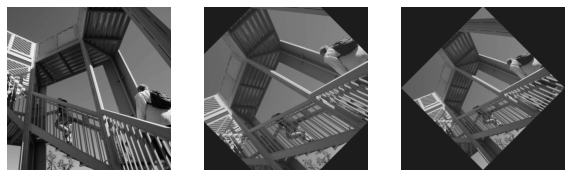

In [ ]:
from scipy import ndimage, misc


fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = misc.ascent()
img_45 = ndimage.rotate(img, 45, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

Data augmentation help from Kaggle [here](https://www.kaggle.com/code/moghazy/guide-to-cnns-with-data-augmentation-keras)